In [1]:
import json
import multiprocessing
import cv2
import albumentations as A
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import pandas as pd
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime
import math
import random

from timm.utils.model_ema import ModelEmaV2

# Config

In [2]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2


class CFG:
    # ============== comp exp name =============
    comp_name = 'atmacup_18'  # comp名

    comp_dataset_path = '../raw/atmacup_18_dataset/'

    exp_name = 'atmacup_18_cnn_swin_small_2'

    is_debug = False
    use_gray_scale = False

    model_in_chans = 9  # モデルの入力チャンネル数

    # ============== file path =============
    train_fold_dir = "../proc/baseline/folds"

    # ============== model cfg =============
    model_name = "swin_small_patch4_window7_224"

    num_frames = 3  # model_in_chansの倍数
    norm_in_chans = 1 if use_gray_scale else 3

    use_torch_compile = False
    use_ema = True
    ema_decay = 0.995
    # ============== training cfg =============
    size = 224  # 224

    batch_size = 64  # 32

    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 40
    if is_debug:
        epochs = 2

    # adamW warmupあり
    warmup_factor = 10
    lr = 1e-4
    if scheduler == 'GradualWarmupSchedulerV2':
        lr /= warmup_factor

    # ============== fold =============
    n_fold = 5
    use_holdout = False
    use_alldata = False
    train_folds = [0, 1, 2, 3, 4]

    skf_col = 'class'
    group_col = 'scene'
    fold_type = 'gkf'

    objective_cv = 'regression'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'minimize'  # 'maximize', 'minimize'
    metrics = 'calc_mae_atmacup'

    # ============== pred target =============
    target_size = 18
    target_col = ['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2',
                  'z_2', 'x_3', 'y_3', 'z_3', 'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5']


    # ============== ほぼ固定 =============
    pretrained = True
    inf_weight = 'last'  # 'best'

    min_lr = 1e-8
    weight_decay = 1e-5
    max_grad_norm = 1000

    print_freq = 500
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    if exp_name is not None:
        print('set dataset path')

        outputs_path = f'../proc/baseline/outputs/{exp_name}/'

        submission_dir = outputs_path + 'submissions/'
        submission_path = submission_dir + f'submission_{exp_name}.csv'

        model_dir = outputs_path + \
            f'{comp_name}-models/'

        figures_dir = outputs_path + 'figures/'

        log_dir = outputs_path + 'logs/'
        log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.Downscale(p=0.25),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        # A.RandomRotate90(p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        # A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        # A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        # A.CoarseDropout(max_holes=1, max_height=int(
        #     size * 0.3), max_width=int(size * 0.3), p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),

        A.Normalize(
            mean=[0] * norm_in_chans*num_frames,
            std=[1] * norm_in_chans*num_frames, 
        ),
        ToTensorV2(),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * norm_in_chans*num_frames,
            std=[1] * norm_in_chans*num_frames,
        ),
        ToTensorV2(),
    ]

set dataset path


In [3]:
print("CUDA が利用可能か:", torch.cuda.is_available())
print("利用可能な CUDA デバイス数:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("現在の CUDA デバイス:", torch.cuda.get_device_name(0))

CUDA が利用可能か: True
利用可能な CUDA デバイス数: 1
現在の CUDA デバイス: NVIDIA GeForce RTX 3090


# make fold

In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


def get_fold(train, cfg):
    if cfg.fold_type == 'kf':
        Fold = KFold(n_splits=cfg.n_fold,
                     shuffle=True, random_state=cfg.seed)
        kf = Fold.split(train, train[cfg.target_col])
    elif cfg.fold_type == 'skf':
        Fold = StratifiedKFold(n_splits=cfg.n_fold,
                               shuffle=True, random_state=cfg.seed)
        kf = Fold.split(train, train[cfg.skf_col])
    elif cfg.fold_type == 'gkf':
        Fold = GroupKFold(n_splits=cfg.n_fold)
        groups = train[cfg.group_col].values
        kf = Fold.split(train, train[cfg.group_col], groups)
    elif cfg.fold_type == 'sgkf':
        Fold = StratifiedGroupKFold(n_splits=cfg.n_fold,
                                    shuffle=True, random_state=cfg.seed)
        groups = train[cfg.group_col].values
        kf = Fold.split(train, train[cfg.skf_col], groups)
    # elif fold_type == 'mskf':
    #     Fold = MultilabelStratifiedKFold(
    #         n_splits=cfg.n_fold, shuffle=True, random_state=cfg.seed)
    #     kf = Fold.split(train, train[cfg.skf_col])

    for n, (train_index, val_index) in enumerate(kf):
        train.loc[val_index, 'fold'] = int(n)
    train['fold'] = train['fold'].astype(int)

    print(train.groupby('fold').size())

    return train

In [5]:
def make_train_folds():
    train_df = pd.read_csv(CFG.comp_dataset_path + 'train_features.csv')

    train_df['scene'] = train_df['ID'].str.split('_').str[0]

    print('group', CFG.group_col)
    print(f'train len: {len(train_df)}')

    train_df = get_fold(train_df, CFG)

    # print(train_df.groupby(['fold', CFG.target_col]).size())
    print(train_df['fold'].value_counts())

    os.makedirs(CFG.train_fold_dir, exist_ok=True)

    train_df.to_csv(CFG.train_fold_dir +
                    'train_folds.csv', index=False)

In [6]:
make_train_folds()

group scene
train len: 43371
fold
0    8675
1    8674
2    8674
3    8674
4    8674
dtype: int64
fold
0    8675
1    8674
2    8674
3    8674
4    8674
Name: count, dtype: int64


# setting

In [7]:
# 乱数固定
def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)

    if mode == 'train':
        make_dirs(cfg)

In [8]:
cfg_init(CFG)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# logger

In [10]:
# from common_utils.logger import init_logger, wandb_init, AverageMeter, timeSince
# from common_utils.settings import cfg_init

def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [11]:
Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------
2024年11月21日 23:09:40


# eval function

In [12]:
def get_score(y_true, y_pred):
    # return roc_auc_score(y_true, y_pred)
    eval_func = eval(CFG.metrics)
    return eval_func(y_true, y_pred)


def calc_mae_atmacup(y_true, y_pred):
    abs_diff = np.abs(y_true - y_pred)  # 各予測の差分の絶対値を計算して
    mae = np.mean(abs_diff.reshape(-1, ))  # 予測の差分の絶対値の平均を計算

    return mae

def get_result(result_df):

    # preds = result_df['preds'].values

    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]
    preds = result_df[pred_cols].values
    labels = result_df[CFG.target_col].values
    score = get_score(labels, preds)
    Logger.info(f'score: {score:<.4f}')

    return score

# image utils

In [13]:
def draw_traffic_light(image, id):
    path = f'./datasets/atmacup_18/traffic_lights/{id}.json'
    traffic_lights = json.load(open(path))

    traffic_class = ['green',
                     'straight', 'left', 'right', 'empty', 'other', 'yellow', 'red']
    class_to_idx = {
        cls: idx for idx, cls in enumerate(traffic_class)
    }

    for traffic_light in traffic_lights:
        bbox = traffic_light['bbox']
        x1, y1, x2, y2 = bbox
        # int
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        point1 = (x1, y1)
        point2 = (x2, y2)

        idx = class_to_idx[traffic_light['class']]
        color = 255 - int(255*(idx/len(traffic_class)))

        cv2.rectangle(image, point1, point2, color=color, thickness=1)

    return image


def read_image_for_cache(path):
    if CFG.use_gray_scale:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # image = cv2.resize(image, (CFG.size, CFG.size))

    # 効かない
    # image = draw_traffic_light(image, path.split('/')[-2])
    return (path, image)


def make_video_cache(paths):
    debug = []
    for idx in range(9):
        color = 255 - int(255*(idx/9))
        debug.append(color)
    print(debug)

    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        res = pool.imap_unordered(read_image_for_cache, paths)
        res = tqdm(res)
        res = list(res)

    return dict(res)

# dataset

In [14]:
from albumentations import ReplayCompose
from torch.utils.data import DataLoader, Dataset
import albumentations as A

def get_transforms(data, cfg):
    if data == 'train':
        # aug = A.Compose(cfg.train_aug_list)
        aug = A.ReplayCompose(cfg.train_aug_list)
    elif data == 'valid':
        # aug = A.Compose(cfg.valid_aug_list)
        aug = A.ReplayCompose(cfg.valid_aug_list)

    # print(aug)
    return aug


class CustomDataset(Dataset):
    def __init__(self, df, cfg, labels=None, transform=None):
        self.df = df
        self.cfg = cfg
        self.base_paths = df['base_path'].values
        # self.labels = df[self.cfg.target_col].values
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def read_image_multiframe(self, idx):
        base_path = self.base_paths[idx]

        images = []
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix

            image = self.cfg.video_cache[path]

            images.append(image)
        return images

    def __getitem__(self, idx):
        image = self.read_image_multiframe(idx)

        if self.transform:
            # image = self.transform(image=image)['image']
            replay = None
            images = []
            for img in image:
                if replay is None:
                    sample = self.transform(image=img)
                    replay = sample['replay']
                else:
                    sample = ReplayCompose.replay(replay, image=img)
                images.append(sample['image'])

            image = torch.concat(images, dim=0)

        if self.labels is None:
            return image

        if self.cfg.objective_cv == 'multiclass':
            label = torch.tensor(self.labels[idx]).long()
        else:
            label = torch.tensor(self.labels[idx]).float()

        return image, label

In [15]:
def plot_aug_video(train, cfg, plot_count=1):
    transform = CFG.train_aug_list
    transform = A.ReplayCompose(transform)

    dataset = CustomDataset(
        train, CFG, transform=transform)

    for i in range(plot_count):
        image = dataset.read_image_multiframe(i)

        if cfg.use_gray_scale:
            image = np.stack(image, axis=2)
        else:
            image = np.concatenate(image, axis=2)

        aug_image = dataset[i]
        # torch to numpy
        aug_image = aug_image.permute(1, 2, 0).numpy()*255

        for frame in range(image.shape[-1]):
            if frame % 3 != 0:
                continue

            fig, axes = plt.subplots(1, 2, figsize=(15, 6))

            if cfg.use_gray_scale:
                axes[0].imshow(image[..., frame], cmap="gray")
                axes[1].imshow(aug_image[..., frame], cmap="gray")
            else:
                axes[0].imshow(image[..., frame:frame+3].astype(int))
                axes[1].imshow(aug_image[..., frame:frame+3].astype(int))
            plt.savefig(cfg.figures_dir +
                        f'aug_{i}_frame{frame}.png')

# model

In [16]:
import timm

class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False, target_size=None, model_name=None):
        super().__init__()
        # self.cfg = cfg

        if model_name is None:
            model_name = cfg.model_name

        print(f'pretrained: {pretrained}')

        self.model = timm.create_model(
            model_name, pretrained=pretrained, num_classes=0,
            in_chans=cfg.model_in_chans)

        # モデルの出力サイズを取得
        if hasattr(self.model, 'num_features'):
            self.n_features = self.model.num_features  # num_featuresで取得するモデルが多い
        elif hasattr(self.model, 'classifier') and hasattr(self.model.classifier, 'in_features'):
            self.n_features = self.model.classifier.in_features  # classifierが存在する場合
        elif hasattr(self.model, 'fc') and hasattr(self.model.fc, 'in_features'):
            self.n_features = self.model.fc.in_features  # fcが存在する場合
        else:
            raise AttributeError("Could not find the output feature size.")

        self.target_size = cfg.target_size if target_size is None else target_size

        # nn.Dropout(0.5),
        self.final_fc = nn.Sequential(
            nn.Linear(self.n_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, self.target_size),
        )

    def feature(self, image):

        feature = self.model(image)
        return feature

    def forward(self, image):
        feature = self.feature(image)
        output = self.final_fc(feature)
        return output

# scheduler

In [17]:
import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    if cfg.scheduler == 'ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(
            optimizer, mode='min', factor=cfg.factor, patience=cfg.patience, verbose=True, eps=cfg.eps)
    elif cfg.scheduler == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(
            optimizer, T_max=cfg.epochs, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer, T_0=cfg.T_0, T_mult=1, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler == 'GradualWarmupSchedulerV2':
        scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, cfg.epochs, eta_min=1e-7)
        scheduler = GradualWarmupSchedulerV2(
            optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    elif isinstance(scheduler, GradualWarmupSchedulerV2):
        scheduler.step(epoch)

# train

In [18]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device,
             model_ema=None):
    """ 1epoch毎のtrain """

    model.train()
    scaler = GradScaler(enabled=CFG.use_amp)

    losses = AverageMeter()
    preds = []
    preds_labels = []
    start = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)

            if y_preds.size(1) == 1:
                y_preds = y_preds.view(-1)

            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()

        if model_ema is not None:
            model_ema.update(model)

        optimizer.zero_grad()
        global_step += 1

        if CFG.objective_cv == 'binary':
            preds.append(torch.sigmoid(y_preds).detach().to('cpu').numpy())
        elif CFG.objective_cv == 'multiclass':
            preds.append(y_preds.softmax(1).detach().to('cpu').numpy())
        elif CFG.objective_cv == 'regression':
            preds.append(y_preds.detach().to('cpu').numpy())

        preds_labels.append(labels.detach().to('cpu').numpy())

        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(epoch + 1, step, len(train_loader),
                          remain=timeSince(start, float(
                              step + 1) / len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
    predictions = np.concatenate(preds)
    labels = np.concatenate(preds_labels)
    return losses.avg, predictions, labels


def valid_fn(valid_loader, model, criterion, device):

    model.eval()
    losses = AverageMeter()
    preds = []
    start = time.time()

    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)

        if y_preds.size(1) == 1:
            y_preds = y_preds.view(-1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # binary
        if CFG.objective_cv == 'binary':
            preds.append(torch.sigmoid(y_preds).to('cpu').numpy())
        elif CFG.objective_cv == 'multiclass':
            preds.append(y_preds.softmax(1).to('cpu').numpy())
        elif CFG.objective_cv == 'regression':
            preds.append(y_preds.to('cpu').numpy())

        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step + 1) / len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [19]:
def train_fold(folds, fold):

    Logger.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    if CFG.use_alldata:
        train_folds = folds.copy().reset_index(drop=True)
    else:
        train_folds = folds.loc[trn_idx].reset_index(drop=True)

    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    # train_folds = train_downsampling(train_folds)

    train_labels = train_folds[CFG.target_col].values
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = CustomDataset(
        train_folds, CFG, labels=train_labels, transform=get_transforms(data='train', cfg=CFG))
    valid_dataset = CustomDataset(
        valid_folds, CFG, labels=valid_labels, transform=get_transforms(data='valid', cfg=CFG))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                              )
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================

    model = CustomModel(CFG, pretrained=CFG.pretrained)
    model.to(device)

    if CFG.use_ema:
        model_ema = ModelEmaV2(model, decay=CFG.ema_decay)
    else:
        model_ema = None

    optimizer = AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    # ====================================================
    # loop
    # ====================================================
    if CFG.objective_cv == 'binary':
        criterion = nn.BCEWithLogitsLoss()
    elif CFG.objective_cv == 'multiclass':
        criterion = nn.CrossEntropyLoss()
    elif CFG.objective_cv == 'regression':
        criterion = nn.L1Loss()

    if CFG.metric_direction == 'minimize':
        best_score = np.inf
    elif CFG.metric_direction == 'maximize':
        best_score = -1

    best_loss = np.inf

    df_score = pd.DataFrame(columns=["train_loss", 'train_score', 'val_loss', 'val_score'])

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss, train_preds, train_labels_epoch = train_fn(fold, train_loader, model,
                                                             criterion, optimizer, epoch, scheduler, device, model_ema)
        train_score = get_score(train_labels_epoch, train_preds)

        # eval
        if model_ema is not None:
            avg_val_loss, valid_preds = valid_fn(
                valid_loader, model_ema.module, criterion, device)
        else:
            avg_val_loss, valid_preds = valid_fn(
                valid_loader, model, criterion, device)

        scheduler_step(scheduler, avg_val_loss, epoch)

        # scoring
        score = get_score(valid_labels, valid_preds)

        elapsed = time.time() - start_time

        Logger.info(
            f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
        Logger.info(
            f'Epoch {epoch+1} - avg_train_Score: {train_score:.4f} avgScore: {score:.4f}')
        
        df_score.loc[epoch] = [avg_loss, train_score, avg_val_loss, score]

        if CFG.metric_direction == 'minimize':
            update_best = score < best_score
        elif CFG.metric_direction == 'maximize':
            update_best = score > best_score

        if update_best:
            best_loss = avg_val_loss
            best_score = score

            Logger.info(
                f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            Logger.info(
                f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')

            if model_ema is not None:
                torch.save({'model': model_ema.module.state_dict(),
                            'preds': valid_preds},
                           CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')
            else:
                torch.save({'model': model.state_dict(),
                            'preds': valid_preds},
                           CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

    """
    torch.save({'model': model.state_dict(),
                'preds': valid_preds},
               CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
    """
    if model_ema is not None:
        torch.save({'model': model_ema.module.state_dict(),
                    'preds': valid_preds},
                   CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
    else:
        torch.save({'model': model.state_dict(),
                    'preds': valid_preds},
                   CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')

    check_point = torch.load(
        CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))
    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]

    check_point_pred = check_point['preds']

    # Columns must be same length as key 対策
    if check_point_pred.ndim == 1:
        check_point_pred = check_point_pred.reshape(-1, CFG.target_size)

    print('check_point_pred shape', check_point_pred.shape)
    valid_folds[pred_cols] = check_point_pred
    return valid_folds, df_score

# train main

In [20]:
def main():
    train = pd.read_csv(CFG.train_fold_dir + 'train_folds.csv')
    train['ori_idx'] = train.index

    train['scene'] = train['ID'].str.split('_').str[0]

    """
    if CFG.is_debug:
        use_ids = train['scene'].unique()[:100]
        train = train[train['scene'].isin(use_ids)].reset_index(drop=True)
    """

    train['base_path'] = CFG.comp_dataset_path + 'images/' + train['ID'] + '/'

    paths = []
    for base_path in train['base_path'].values:
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix
            paths.append(path)

    print(paths[:5])

    CFG.video_cache = make_video_cache(paths)

    # plot_aug_video(train, CFG, plot_count=10)

    # train
    oof_df = pd.DataFrame()
    list_df_score = []
    for fold in range(CFG.n_fold):
        if fold not in CFG.train_folds:
            print(f'fold {fold} is skipped')
            continue

        _oof_df, _df_score = train_fold(train, fold)
        oof_df = pd.concat([oof_df, _oof_df])
        list_df_score.append(_df_score)
        Logger.info(f"========== fold: {fold} result ==========")
        get_result(_oof_df)

        if CFG.use_holdout or CFG.use_alldata:
            break

    oof_df = oof_df.sort_values('ori_idx').reset_index(drop=True)

    # CV result
    Logger.info("========== CV ==========")
    score = get_result(oof_df)

    # 学習曲線を可視化する
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.grid(alpha=0.1)
    ax2.grid(alpha=0.1)
    for i, df_score in enumerate(list_df_score):
        ax1.plot(df_score['train_score'], label=f'fold {i}')
        ax2.plot(df_score['val_score'], label=f'fold {i}')
    ax1.set_title('Train Score')
    ax2.set_title('Val Score') 
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    ax1.set_ylabel('Train Score')
    ax2.set_ylabel('Val Score')
    plt.tight_layout()
    plt.savefig(CFG.figures_dir + f'learning_curve_{CFG.exp_name}.png')
    plt.show()

    # save result
    oof_df.to_csv(CFG.submission_dir + 'oof_cv.csv', index=False)

['../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t-1.0.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t-0.5.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_420/image_t-1.0.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_420/image_t-0.5.png']
[255, 227, 199, 170, 142, 114, 85, 57, 29]


0it [00:00, ?it/s]

========== fold: 0 training ==========


pretrained: True


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 2s (remain 20m 28s) Loss: 6.0125(6.0125) Grad: inf  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 4.6669(5.2647) Grad: 21603.8887  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 4.4345(5.2420) Grad: 23755.6484  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 48s) Loss: 4.7394(4.7394) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 5.2420  avg_val_loss: 5.2858  time: 131s
Epoch 1 - avg_train_Score: 5.2420 avgScore: 5.2858


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 4.8063(5.2858) 


Epoch 1 - Save Best Score: 5.2858 Model
Epoch 1 - Save Best Loss: 5.2858 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 11m 45s) Loss: 5.1981(5.1981) Grad: 301958.0625  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 4.1290(4.9653) Grad: 50945.7852  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 4.5313(4.9551) Grad: 75085.0938  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 4.4533(4.4533) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 4.9551  avg_val_loss: 4.9773  time: 130s
Epoch 2 - avg_train_Score: 4.9551 avgScore: 4.9773
Epoch 2 - Save Best Score: 4.9773 Model
Epoch 2 - Save Best Loss: 4.9773 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 4.5242(4.9773) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 11m 48s) Loss: 5.6882(5.6882) Grad: 210391.9844  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 2.5645(3.8669) Grad: 20414.2148  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 2.1014(3.7632) Grad: 22071.3926  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 2.6025(2.6025) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 3.7632  avg_val_loss: 3.1532  time: 130s
Epoch 3 - avg_train_Score: 3.7632 avgScore: 3.1532
Epoch 3 - Save Best Score: 3.1532 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 3.0079(3.1532) 


Epoch 3 - Save Best Loss: 3.1532 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 12m 19s) Loss: 2.4214(2.4214) Grad: 516767.5938  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.3973(1.7476) Grad: 53443.2500  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.4580(1.7240) Grad: 18416.2344  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 1.1237(1.1237) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.7240  avg_val_loss: 1.2563  time: 130s
Epoch 4 - avg_train_Score: 1.7240 avgScore: 1.2563
Epoch 4 - Save Best Score: 1.2563 Model
Epoch 4 - Save Best Loss: 1.2563 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 1.2275(1.2563) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 12m 2s) Loss: 1.2583(1.2583) Grad: 275720.1250  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.4816(1.3040) Grad: 44387.6406  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0132(1.3064) Grad: 30606.7188  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 1.0150(1.0150) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 1.3064  avg_val_loss: 1.0319  time: 130s
Epoch 5 - avg_train_Score: 1.3064 avgScore: 1.0319
Epoch 5 - Save Best Score: 1.0319 Model
Epoch 5 - Save Best Loss: 1.0319 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.0594(1.0319) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 12m 5s) Loss: 1.5693(1.5693) Grad: 392394.1875  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.1368(1.1847) Grad: 80076.7422  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.6822(1.1832) Grad: 87447.5391  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.9628(0.9628) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 1.1832  avg_val_loss: 0.9794  time: 130s
Epoch 6 - avg_train_Score: 1.1832 avgScore: 0.9794
Epoch 6 - Save Best Score: 0.9794 Model
Epoch 6 - Save Best Loss: 0.9794 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9857(0.9794) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 12m 0s) Loss: 1.0242(1.0242) Grad: 434281.1250  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9891(1.1572) Grad: 16317.4697  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.1288(1.1622) Grad: 15975.4336  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.9291(0.9291) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 1.1622  avg_val_loss: 0.9698  time: 130s
Epoch 7 - avg_train_Score: 1.1622 avgScore: 0.9698
Epoch 7 - Save Best Score: 0.9698 Model
Epoch 7 - Save Best Loss: 0.9698 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9905(0.9698) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 12m 7s) Loss: 1.2593(1.2593) Grad: 323271.7188  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 1.0299(1.1001) Grad: 33503.8477  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.2650(1.0994) Grad: 26333.3848  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.8699(0.8699) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 1.0994  avg_val_loss: 0.9380  time: 129s
Epoch 8 - avg_train_Score: 1.0994 avgScore: 0.9380
Epoch 8 - Save Best Score: 0.9380 Model
Epoch 8 - Save Best Loss: 0.9380 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.9522(0.9380) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 12m 51s) Loss: 0.8201(0.8201) Grad: 246771.5000  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0174(1.0237) Grad: 26145.3652  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8406(1.0247) Grad: 33598.2539  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.8676(0.8676) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 1.0247  avg_val_loss: 0.9093  time: 130s
Epoch 9 - avg_train_Score: 1.0247 avgScore: 0.9093
Epoch 9 - Save Best Score: 0.9093 Model
Epoch 9 - Save Best Loss: 0.9093 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9437(0.9093) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 12m 15s) Loss: 0.9344(0.9344) Grad: 280299.2812  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0596(0.9748) Grad: 67658.0781  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8267(0.9735) Grad: 54645.0859  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.8847(0.8847) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.9735  avg_val_loss: 0.8968  time: 130s
Epoch 10 - avg_train_Score: 0.9735 avgScore: 0.8968
Epoch 10 - Save Best Score: 0.8968 Model
Epoch 10 - Save Best Loss: 0.8968 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9024(0.8968) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 12m 32s) Loss: 0.7831(0.7831) Grad: 282077.5000  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9216(0.9285) Grad: 35450.9297  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9786(0.9319) Grad: 28746.5547  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 47s) Loss: 0.8633(0.8633) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9014(0.8807) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.9319  avg_val_loss: 0.8807  time: 130s
Epoch 11 - avg_train_Score: 0.9319 avgScore: 0.8807
Epoch 11 - Save Best Score: 0.8807 Model
Epoch 11 - Save Best Loss: 0.8807 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [12][0/542] Elapsed 0m 1s (remain 12m 23s) Loss: 0.8734(0.8734) Grad: 206552.1875  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.2348(0.9504) Grad: 33138.2227  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8886(0.9485) Grad: 33779.0312  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.8861(0.8861) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.9485  avg_val_loss: 0.8779  time: 130s
Epoch 12 - avg_train_Score: 0.9485 avgScore: 0.8779
Epoch 12 - Save Best Score: 0.8779 Model
Epoch 12 - Save Best Loss: 0.8779 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9125(0.8779) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 11m 59s) Loss: 0.8950(0.8950) Grad: 239911.4375  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7091(0.8924) Grad: 45141.5117  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9193(0.8947) Grad: 70701.9453  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.8516(0.8516) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.8947  avg_val_loss: 0.8688  time: 130s
Epoch 13 - avg_train_Score: 0.8947 avgScore: 0.8688
Epoch 13 - Save Best Score: 0.8688 Model
Epoch 13 - Save Best Loss: 0.8688 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8773(0.8688) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 12m 5s) Loss: 0.7548(0.7548) Grad: 345312.4375  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7697(0.8955) Grad: 72800.3438  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7918(0.8940) Grad: 55547.1289  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.8405(0.8405) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.8940  avg_val_loss: 0.8644  time: 130s
Epoch 14 - avg_train_Score: 0.8940 avgScore: 0.8644
Epoch 14 - Save Best Score: 0.8644 Model
Epoch 14 - Save Best Loss: 0.8644 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8794(0.8644) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 12m 12s) Loss: 1.0050(1.0050) Grad: 225660.8438  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7820(0.8693) Grad: 116637.6328  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.1200(0.8734) Grad: 46483.5039  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.8360(0.8360) 
EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8622(0.8562) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.8734  avg_val_loss: 0.8562  time: 130s
Epoch 15 - avg_train_Score: 0.8734 avgScore: 0.8562
Epoch 15 - Save Best Score: 0.8562 Model
Epoch 15 - Save Best Loss: 0.8562 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [16][0/542] Elapsed 0m 1s (remain 12m 27s) Loss: 0.8178(0.8178) Grad: 295174.3750  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 1.1493(0.8544) Grad: 57796.5000  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7147(0.8542) Grad: 53409.2109  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.8268(0.8268) 
EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8573(0.8542) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.8542  avg_val_loss: 0.8542  time: 129s
Epoch 16 - avg_train_Score: 0.8542 avgScore: 0.8542
Epoch 16 - Save Best Score: 0.8542 Model
Epoch 16 - Save Best Loss: 0.8542 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [17][0/542] Elapsed 0m 1s (remain 12m 20s) Loss: 0.7346(0.7346) Grad: 535046.5000  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9841(0.8397) Grad: 23429.5859  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7450(0.8399) Grad: 33434.1250  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.8192(0.8192) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8498(0.8481) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.8399  avg_val_loss: 0.8481  time: 130s
Epoch 17 - avg_train_Score: 0.8399 avgScore: 0.8481
Epoch 17 - Save Best Score: 0.8481 Model
Epoch 17 - Save Best Loss: 0.8481 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [18][0/542] Elapsed 0m 1s (remain 12m 22s) Loss: 0.8950(0.8950) Grad: 289149.8125  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 0.6363(0.8568) Grad: 28002.0645  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7936(0.8565) Grad: 47823.4102  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.8360(0.8360) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.8565  avg_val_loss: 0.8497  time: 130s
Epoch 18 - avg_train_Score: 0.8565 avgScore: 0.8497


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8727(0.8497) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 13m 1s) Loss: 0.8052(0.8052) Grad: 334409.1250  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7830(0.8033) Grad: 49084.5039  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7674(0.8020) Grad: 69197.3359  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.8129(0.8129) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8425(0.8382) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.8020  avg_val_loss: 0.8382  time: 130s
Epoch 19 - avg_train_Score: 0.8020 avgScore: 0.8382
Epoch 19 - Save Best Score: 0.8382 Model
Epoch 19 - Save Best Loss: 0.8382 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [20][0/542] Elapsed 0m 1s (remain 12m 35s) Loss: 1.0387(1.0387) Grad: 160255.1875  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6812(0.7847) Grad: 62550.2695  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7287(0.7843) Grad: 78707.3750  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.7974(0.7974) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.7843  avg_val_loss: 0.8394  time: 130s
Epoch 20 - avg_train_Score: 0.7843 avgScore: 0.8394


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8361(0.8394) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 12m 5s) Loss: 0.5759(0.5759) Grad: 225143.9375  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 0.9383(0.8140) Grad: 47688.3711  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7311(0.8120) Grad: 25439.8438  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.8015(0.8015) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8380(0.8398) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.8120  avg_val_loss: 0.8398  time: 130s
Epoch 21 - avg_train_Score: 0.8120 avgScore: 0.8398
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [22][0/542] Elapsed 0m 1s (remain 11m 51s) Loss: 0.7014(0.7014) Grad: 204528.5938  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7570(0.7729) Grad: 106811.8750  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6880(0.7732) Grad: 87959.7109  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7925(0.7925) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8244(0.8341) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.7732  avg_val_loss: 0.8341  time: 130s
Epoch 22 - avg_train_Score: 0.7732 avgScore: 0.8341
Epoch 22 - Save Best Score: 0.8341 Model
Epoch 22 - Save Best Loss: 0.8341 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [23][0/542] Elapsed 0m 1s (remain 12m 5s) Loss: 1.3625(1.3625) Grad: 604404.5000  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5753(0.7573) Grad: 122864.5938  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6645(0.7564) Grad: 84172.1406  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.7964(0.7964) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.7564  avg_val_loss: 0.8315  time: 130s
Epoch 23 - avg_train_Score: 0.7564 avgScore: 0.8315
Epoch 23 - Save Best Score: 0.8315 Model
Epoch 23 - Save Best Loss: 0.8315 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8157(0.8315) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 12m 44s) Loss: 0.5445(0.5445) Grad: 180028.4844  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7531(0.7477) Grad: 41840.0000  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5894(0.7527) Grad: 98471.5625  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7944(0.7944) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.7527  avg_val_loss: 0.8300  time: 130s
Epoch 24 - avg_train_Score: 0.7527 avgScore: 0.8300
Epoch 24 - Save Best Score: 0.8300 Model
Epoch 24 - Save Best Loss: 0.8300 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8067(0.8300) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 12m 31s) Loss: 0.7599(0.7599) Grad: 404482.8438  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 1.0364(0.7411) Grad: 95134.2734  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 0.7848(0.7398) Grad: 107364.7188  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7715(0.7715) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.7398  avg_val_loss: 0.8286  time: 131s
Epoch 25 - avg_train_Score: 0.7398 avgScore: 0.8286
Epoch 25 - Save Best Score: 0.8286 Model
Epoch 25 - Save Best Loss: 0.8286 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8053(0.8286) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 12m 28s) Loss: 0.8250(0.8250) Grad: 188428.2812  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5555(0.7300) Grad: 94749.5703  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7295(0.7259) Grad: 83202.5859  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7942(0.7942) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.7259  avg_val_loss: 0.8269  time: 130s
Epoch 26 - avg_train_Score: 0.7259 avgScore: 0.8269
Epoch 26 - Save Best Score: 0.8269 Model
Epoch 26 - Save Best Loss: 0.8269 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8016(0.8269) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 13m 9s) Loss: 0.6155(0.6155) Grad: 224099.6875  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0667(0.7362) Grad: 40301.5977  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6404(0.7389) Grad: 24280.4609  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7841(0.7841) 
EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8029(0.8274) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.7389  avg_val_loss: 0.8274  time: 130s
Epoch 27 - avg_train_Score: 0.7389 avgScore: 0.8274
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [28][0/542] Elapsed 0m 1s (remain 12m 51s) Loss: 0.7563(0.7563) Grad: 237540.1094  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6534(0.7233) Grad: 101982.6328  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7270(0.7188) Grad: 102246.5234  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.8168(0.8168) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.7188  avg_val_loss: 0.8255  time: 130s
Epoch 28 - avg_train_Score: 0.7188 avgScore: 0.8255
Epoch 28 - Save Best Score: 0.8255 Model
Epoch 28 - Save Best Loss: 0.8255 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8121(0.8255) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 12m 40s) Loss: 1.0346(1.0346) Grad: 169125.6250  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8726(0.7132) Grad: 47342.1914  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.3712(0.7170) Grad: 46876.2109  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.8052(0.8052) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.7170  avg_val_loss: 0.8237  time: 130s
Epoch 29 - avg_train_Score: 0.7170 avgScore: 0.8237
Epoch 29 - Save Best Score: 0.8237 Model
Epoch 29 - Save Best Loss: 0.8237 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8161(0.8237) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 12m 13s) Loss: 0.6995(0.6995) Grad: 224716.4531  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 0.7022(0.7153) Grad: 39264.2617  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5138(0.7152) Grad: 69308.5078  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7913(0.7913) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.7152  avg_val_loss: 0.8227  time: 129s
Epoch 30 - avg_train_Score: 0.7152 avgScore: 0.8227
Epoch 30 - Save Best Score: 0.8227 Model
Epoch 30 - Save Best Loss: 0.8227 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8136(0.8227) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 12m 57s) Loss: 0.5799(0.5799) Grad: 167623.3125  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5820(0.7089) Grad: 108959.2656  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8809(0.7076) Grad: 119887.9922  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7817(0.7817) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.7076  avg_val_loss: 0.8237  time: 130s
Epoch 31 - avg_train_Score: 0.7076 avgScore: 0.8237


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8036(0.8237) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 11m 54s) Loss: 0.5409(0.5409) Grad: 218411.0469  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6122(0.7005) Grad: 87228.8906  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6524(0.6993) Grad: 83961.8438  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7863(0.7863) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.6993  avg_val_loss: 0.8210  time: 130s
Epoch 32 - avg_train_Score: 0.6993 avgScore: 0.8210
Epoch 32 - Save Best Score: 0.8210 Model
Epoch 32 - Save Best Loss: 0.8210 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7940(0.8210) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 11m 58s) Loss: 0.7670(0.7670) Grad: 179023.7344  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 0.5830(0.6963) Grad: 62721.8164  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8888(0.6972) Grad: 19444.1953  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.7889(0.7889) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.6972  avg_val_loss: 0.8200  time: 130s
Epoch 33 - avg_train_Score: 0.6972 avgScore: 0.8200
Epoch 33 - Save Best Score: 0.8200 Model
Epoch 33 - Save Best Loss: 0.8200 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8038(0.8200) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 12m 12s) Loss: 0.5934(0.5934) Grad: 153365.9844  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5220(0.6951) Grad: 86570.0391  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6767(0.6937) Grad: 116093.1719  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.7922(0.7922) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.6937  avg_val_loss: 0.8215  time: 130s
Epoch 34 - avg_train_Score: 0.6937 avgScore: 0.8215


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8113(0.8215) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 12m 8s) Loss: 0.7536(0.7536) Grad: 190961.4844  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8067(0.6948) Grad: 54052.1523  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.4962(0.6949) Grad: 44611.0508  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7868(0.7868) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.6949  avg_val_loss: 0.8203  time: 130s
Epoch 35 - avg_train_Score: 0.6949 avgScore: 0.8203


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8105(0.8203) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 12m 33s) Loss: 0.7199(0.7199) Grad: 240363.8906  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7754(0.6892) Grad: 36200.9531  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.3165(0.6921) Grad: 34283.6602  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7770(0.7770) 
EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8136(0.8197) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.6921  avg_val_loss: 0.8197  time: 130s
Epoch 36 - avg_train_Score: 0.6921 avgScore: 0.8197
Epoch 36 - Save Best Score: 0.8197 Model
Epoch 36 - Save Best Loss: 0.8197 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [37][0/542] Elapsed 0m 1s (remain 12m 41s) Loss: 1.0488(1.0488) Grad: 180273.1562  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7642(0.6894) Grad: 46057.7578  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6128(0.6883) Grad: 47172.8125  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7746(0.7746) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.6883  avg_val_loss: 0.8209  time: 130s
Epoch 37 - avg_train_Score: 0.6883 avgScore: 0.8209


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8109(0.8209) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 12m 8s) Loss: 0.6758(0.6758) Grad: 235092.4688  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6738(0.6783) Grad: 37516.9570  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5765(0.6771) Grad: 51962.7891  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7750(0.7750) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.6771  avg_val_loss: 0.8196  time: 130s
Epoch 38 - avg_train_Score: 0.6771 avgScore: 0.8196
Epoch 38 - Save Best Score: 0.8196 Model
Epoch 38 - Save Best Loss: 0.8196 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8151(0.8196) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 12m 6s) Loss: 0.6320(0.6320) Grad: 406282.5312  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5740(0.6774) Grad: 100932.4922  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6416(0.6797) Grad: 87751.0156  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.7703(0.7703) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8084(0.8205) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.6797  avg_val_loss: 0.8205  time: 130s
Epoch 39 - avg_train_Score: 0.6797 avgScore: 0.8205
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [40][0/542] Elapsed 0m 1s (remain 12m 10s) Loss: 0.7657(0.7657) Grad: 284216.8438  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5748(0.6782) Grad: 55797.1445  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5588(0.6801) Grad: 46014.0234  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.7734(0.7734) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.6801  avg_val_loss: 0.8188  time: 130s


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8124(0.8188) 


Epoch 40 - avg_train_Score: 0.6801 avgScore: 0.8188
Epoch 40 - Save Best Score: 0.8188 Model
Epoch 40 - Save Best Loss: 0.8188 Model
/tmp/ipykernel_217129/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any 

check_point_pred shape (8675, 18)
pretrained: True


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 12m 28s) Loss: 4.9714(4.9714) Grad: 253322.9219  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 5.4985(5.3729) Grad: 19259.7363  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 5.0047(5.3566) Grad: 36616.0508  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 48s) Loss: 5.4739(5.4739) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 5.3566  avg_val_loss: 5.1603  time: 130s
Epoch 1 - avg_train_Score: 5.3566 avgScore: 5.1603
Epoch 1 - Save Best Score: 5.1603 Model
Epoch 1 - Save Best Loss: 5.1603 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 3.5336(5.1603) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 12m 26s) Loss: 5.9214(5.9214) Grad: 174646.0625  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 4.7860(5.0537) Grad: 92213.6641  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 5.8172(5.0447) Grad: 74642.6406  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 5.1247(5.1247) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 5.0447  avg_val_loss: 4.7939  time: 130s
Epoch 2 - avg_train_Score: 5.0447 avgScore: 4.7939
Epoch 2 - Save Best Score: 4.7939 Model
Epoch 2 - Save Best Loss: 4.7939 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 3.2772(4.7939) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 12m 18s) Loss: 5.0510(5.0510) Grad: 543450.8125  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 3.0723(3.9287) Grad: 30440.5977  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 2.5823(3.8165) Grad: 99182.4219  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 49s) Loss: 3.6847(3.6847) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 3.8165  avg_val_loss: 3.3023  time: 130s
Epoch 3 - avg_train_Score: 3.8165 avgScore: 3.3023
Epoch 3 - Save Best Score: 3.3023 Model
Epoch 3 - Save Best Loss: 3.3023 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 2.2829(3.3023) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 12m 39s) Loss: 2.0585(2.0585) Grad: 322928.1875  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.5667(1.8036) Grad: 36432.6094  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.5417(1.7789) Grad: 23742.2207  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 1.4518(1.4518) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.7789  avg_val_loss: 1.2184  time: 130s
Epoch 4 - avg_train_Score: 1.7789 avgScore: 1.2184
Epoch 4 - Save Best Score: 1.2184 Model
Epoch 4 - Save Best Loss: 1.2184 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.1793(1.2184) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 12m 23s) Loss: 2.0776(2.0776) Grad: 334082.9062  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9761(1.2995) Grad: 50978.3047  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.4424(1.2966) Grad: 130100.1719  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 1.1631(1.1631) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.0186(1.0128) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 1.2966  avg_val_loss: 1.0128  time: 130s
Epoch 5 - avg_train_Score: 1.2966 avgScore: 1.0128
Epoch 5 - Save Best Score: 1.0128 Model
Epoch 5 - Save Best Loss: 1.0128 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480

Epoch: [6][0/542] Elapsed 0m 1s (remain 14m 31s) Loss: 1.1023(1.1023) Grad: 347664.6562  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0097(1.1898) Grad: 120453.4219  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.2523(1.1882) Grad: 241289.6406  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 51s) Loss: 1.0879(1.0879) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9319(0.9605) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 1.1882  avg_val_loss: 0.9605  time: 131s
Epoch 6 - avg_train_Score: 1.1882 avgScore: 0.9605
Epoch 6 - Save Best Score: 0.9605 Model
Epoch 6 - Save Best Loss: 0.9605 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480

Epoch: [7][0/542] Elapsed 0m 1s (remain 12m 57s) Loss: 1.1523(1.1523) Grad: 432864.1562  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.5409(1.1506) Grad: 54957.1289  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.3154(1.1517) Grad: 82614.2266  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 1.0687(1.0687) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 1.1517  avg_val_loss: 0.9422  time: 130s
Epoch 7 - avg_train_Score: 1.1517 avgScore: 0.9422
Epoch 7 - Save Best Score: 0.9422 Model
Epoch 7 - Save Best Loss: 0.9422 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8969(0.9422) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 12m 37s) Loss: 0.9635(0.9635) Grad: 226846.7500  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7589(1.0857) Grad: 139164.1562  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.3961(1.0836) Grad: 73723.5469  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 1.0273(1.0273) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 1.0836  avg_val_loss: 0.9145  time: 130s
Epoch 8 - avg_train_Score: 1.0836 avgScore: 0.9145
Epoch 8 - Save Best Score: 0.9145 Model
Epoch 8 - Save Best Loss: 0.9145 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8641(0.9145) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 12m 33s) Loss: 1.0048(1.0048) Grad: 353981.8750  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.2072(1.0888) Grad: 52103.8359  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.2347(1.0954) Grad: 48542.6250  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.9894(0.9894) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 1.0954  avg_val_loss: 0.9081  time: 130s
Epoch 9 - avg_train_Score: 1.0954 avgScore: 0.9081
Epoch 9 - Save Best Score: 0.9081 Model
Epoch 9 - Save Best Loss: 0.9081 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8338(0.9081) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 12m 20s) Loss: 0.8409(0.8409) Grad: 286513.5625  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9209(1.0297) Grad: 80876.9219  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0303(1.0302) Grad: 52927.2227  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.9271(0.9271) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 1.0302  avg_val_loss: 0.8835  time: 130s
Epoch 10 - avg_train_Score: 1.0302 avgScore: 0.8835
Epoch 10 - Save Best Score: 0.8835 Model
Epoch 10 - Save Best Loss: 0.8835 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8073(0.8835) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 12m 14s) Loss: 0.9866(0.9866) Grad: 322541.0312  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.1386(1.0101) Grad: 54484.5000  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9034(1.0090) Grad: 72795.4766  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 46s) Loss: 0.8825(0.8825) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 1.0090  avg_val_loss: 0.8712  time: 130s
Epoch 11 - avg_train_Score: 1.0090 avgScore: 0.8712
Epoch 11 - Save Best Score: 0.8712 Model
Epoch 11 - Save Best Loss: 0.8712 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8216(0.8712) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 12m 13s) Loss: 0.8766(0.8766) Grad: 260448.6094  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8674(0.9569) Grad: 77229.5859  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8734(0.9609) Grad: 76707.9375  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.9033(0.9033) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.9609  avg_val_loss: 0.8549  time: 130s
Epoch 12 - avg_train_Score: 0.9609 avgScore: 0.8549
Epoch 12 - Save Best Score: 0.8549 Model
Epoch 12 - Save Best Loss: 0.8549 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8102(0.8549) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 12m 13s) Loss: 0.8830(0.8830) Grad: nan  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8999(0.9913) Grad: 47374.1133  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0202(0.9937) Grad: 31187.5605  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 45s) Loss: 0.8985(0.8985) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.9937  avg_val_loss: 0.8472  time: 130s
Epoch 13 - avg_train_Score: 0.9937 avgScore: 0.8472
Epoch 13 - Save Best Score: 0.8472 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8020(0.8472) 


Epoch 13 - Save Best Loss: 0.8472 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 12m 44s) Loss: 1.0358(1.0358) Grad: 346807.7188  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 0.9683(0.9290) Grad: 61748.9766  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7617(0.9266) Grad: 83613.3828  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 45s) Loss: 0.8879(0.8879) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.9266  avg_val_loss: 0.8418  time: 130s
Epoch 14 - avg_train_Score: 0.9266 avgScore: 0.8418
Epoch 14 - Save Best Score: 0.8418 Model
Epoch 14 - Save Best Loss: 0.8418 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7886(0.8418) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 12m 7s) Loss: 1.0240(1.0240) Grad: nan  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8897(0.8958) Grad: 53011.7852  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7585(0.8988) Grad: 91373.5469  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.8862(0.8862) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7433(0.8220) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.8988  avg_val_loss: 0.8220  time: 130s
Epoch 15 - avg_train_Score: 0.8988 avgScore: 0.8220
Epoch 15 - Save Best Score: 0.8220 Model
Epoch 15 - Save Best Loss: 0.8220 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [16][0/542] Elapsed 0m 1s (remain 12m 28s) Loss: 0.7295(0.7295) Grad: 331729.3438  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 0.8620(0.8718) Grad: 71500.0078  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8277(0.8733) Grad: 79477.2422  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.9272(0.9272) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.8733  avg_val_loss: 0.8272  time: 130s
Epoch 16 - avg_train_Score: 0.8733 avgScore: 0.8272


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7500(0.8272) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 12m 40s) Loss: 0.8762(0.8762) Grad: 309773.9375  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7431(0.8594) Grad: 64076.3945  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6653(0.8570) Grad: 48313.7656  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.8858(0.8858) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.8570  avg_val_loss: 0.8187  time: 130s
Epoch 17 - avg_train_Score: 0.8570 avgScore: 0.8187
Epoch 17 - Save Best Score: 0.8187 Model
Epoch 17 - Save Best Loss: 0.8187 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.7491(0.8187) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 12m 28s) Loss: 0.8745(0.8745) Grad: 247091.2656  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0442(0.8481) Grad: 48077.5430  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8650(0.8477) Grad: 85775.3438  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.8830(0.8830) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7424(0.8199) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.8477  avg_val_loss: 0.8199  time: 130s
Epoch 18 - avg_train_Score: 0.8477 avgScore: 0.8199
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [19][0/542] Elapsed 0m 1s (remain 12m 24s) Loss: 0.7652(0.7652) Grad: 296408.6562  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8552(0.8027) Grad: 100542.2656  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6769(0.8047) Grad: 119274.5312  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.8821(0.8821) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.8047  avg_val_loss: 0.8112  time: 130s
Epoch 19 - avg_train_Score: 0.8047 avgScore: 0.8112
Epoch 19 - Save Best Score: 0.8112 Model
Epoch 19 - Save Best Loss: 0.8112 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.7105(0.8112) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 12m 19s) Loss: 0.7617(0.7617) Grad: 227201.6094  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0377(0.8231) Grad: 63743.8125  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6534(0.8242) Grad: 73369.7500  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.8589(0.8589) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.8242  avg_val_loss: 0.8059  time: 130s
Epoch 20 - avg_train_Score: 0.8242 avgScore: 0.8059
Epoch 20 - Save Best Score: 0.8059 Model
Epoch 20 - Save Best Loss: 0.8059 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7125(0.8059) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 12m 19s) Loss: 0.7372(0.7372) Grad: 218736.1094  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0456(0.8271) Grad: 30781.2988  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8625(0.8293) Grad: 41021.9375  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.8509(0.8509) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.8293  avg_val_loss: 0.8087  time: 130s
Epoch 21 - avg_train_Score: 0.8293 avgScore: 0.8087


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7252(0.8087) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 12m 11s) Loss: 0.7661(0.7661) Grad: 194392.5000  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7029(0.7999) Grad: 53016.4180  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9222(0.8027) Grad: 60636.1250  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.8544(0.8544) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.8027  avg_val_loss: 0.8043  time: 130s
Epoch 22 - avg_train_Score: 0.8027 avgScore: 0.8043
Epoch 22 - Save Best Score: 0.8043 Model
Epoch 22 - Save Best Loss: 0.8043 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7549(0.8043) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 12m 19s) Loss: 0.6888(0.6888) Grad: 218315.0625  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6604(0.7749) Grad: 72508.9141  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8577(0.7777) Grad: 106966.4844  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 47s) Loss: 0.8434(0.8434) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7516(0.7996) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.7777  avg_val_loss: 0.7996  time: 130s
Epoch 23 - avg_train_Score: 0.7777 avgScore: 0.7996
Epoch 23 - Save Best Score: 0.7996 Model
Epoch 23 - Save Best Loss: 0.7996 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [24][0/542] Elapsed 0m 1s (remain 12m 27s) Loss: 0.7179(0.7179) Grad: 257537.0156  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 0.6347(0.7664) Grad: 27849.1426  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6288(0.7699) Grad: 30258.0449  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.8289(0.8289) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.7699  avg_val_loss: 0.7989  time: 130s
Epoch 24 - avg_train_Score: 0.7699 avgScore: 0.7989
Epoch 24 - Save Best Score: 0.7989 Model
Epoch 24 - Save Best Loss: 0.7989 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7351(0.7989) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 12m 22s) Loss: 0.8725(0.8725) Grad: 180544.6250  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9192(0.7593) Grad: 47903.7617  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6019(0.7575) Grad: 57314.3672  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.8370(0.8370) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.7575  avg_val_loss: 0.7957  time: 130s
Epoch 25 - avg_train_Score: 0.7575 avgScore: 0.7957
Epoch 25 - Save Best Score: 0.7957 Model
Epoch 25 - Save Best Loss: 0.7957 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7034(0.7957) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 12m 23s) Loss: 0.5181(0.5181) Grad: 223732.5625  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 0.5657(0.7547) Grad: 32631.4551  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6700(0.7531) Grad: 28500.9980  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.8326(0.8326) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7061(0.7917) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.7531  avg_val_loss: 0.7917  time: 130s
Epoch 26 - avg_train_Score: 0.7531 avgScore: 0.7917
Epoch 26 - Save Best Score: 0.7917 Model
Epoch 26 - Save Best Loss: 0.7917 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [27][0/542] Elapsed 0m 1s (remain 12m 39s) Loss: 0.6480(0.6480) Grad: 222194.3594  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6565(0.7362) Grad: 55869.6602  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6407(0.7362) Grad: 53286.3984  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.8304(0.8304) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.7362  avg_val_loss: 0.7914  time: 130s
Epoch 27 - avg_train_Score: 0.7362 avgScore: 0.7914
Epoch 27 - Save Best Score: 0.7914 Model
Epoch 27 - Save Best Loss: 0.7914 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7176(0.7914) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 12m 56s) Loss: 0.8397(0.8397) Grad: 484140.0938  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 0.7891(0.7301) Grad: 40499.7734  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6271(0.7336) Grad: 30714.4590  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.8281(0.8281) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.7336  avg_val_loss: 0.7883  time: 130s
Epoch 28 - avg_train_Score: 0.7336 avgScore: 0.7883
Epoch 28 - Save Best Score: 0.7883 Model
Epoch 28 - Save Best Loss: 0.7883 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.7035(0.7883) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 12m 5s) Loss: 0.6392(0.6392) Grad: 230496.8438  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9897(0.7402) Grad: 17230.8203  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8181(0.7399) Grad: 10417.8096  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.8302(0.8302) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.7399  avg_val_loss: 0.7923  time: 130s
Epoch 29 - avg_train_Score: 0.7399 avgScore: 0.7923


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.6899(0.7923) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 12m 37s) Loss: 0.7199(0.7199) Grad: 245065.6406  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6283(0.7208) Grad: 73906.9922  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9036(0.7212) Grad: 62714.0938  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 46s) Loss: 0.8175(0.8175) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.7212  avg_val_loss: 0.7931  time: 130s
Epoch 30 - avg_train_Score: 0.7212 avgScore: 0.7931


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.6821(0.7931) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 12m 18s) Loss: 0.5747(0.5747) Grad: 205881.2031  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6129(0.7124) Grad: 49530.2148  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6169(0.7134) Grad: 45893.1953  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.8234(0.8234) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.7134  avg_val_loss: 0.7891  time: 130s
Epoch 31 - avg_train_Score: 0.7134 avgScore: 0.7891


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.6794(0.7891) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 13m 9s) Loss: 0.6985(0.6985) Grad: 173610.8281  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6860(0.7056) Grad: 26974.6387  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7157(0.7081) Grad: 25438.7617  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.8252(0.8252) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.7081  avg_val_loss: 0.7879  time: 130s
Epoch 32 - avg_train_Score: 0.7081 avgScore: 0.7879
Epoch 32 - Save Best Score: 0.7879 Model
Epoch 32 - Save Best Loss: 0.7879 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7010(0.7879) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 12m 55s) Loss: 0.6176(0.6176) Grad: 219075.7344  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8484(0.7039) Grad: 27173.5254  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6678(0.7066) Grad: 24142.8594  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.8179(0.8179) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.7066  avg_val_loss: 0.7843  time: 130s
Epoch 33 - avg_train_Score: 0.7066 avgScore: 0.7843
Epoch 33 - Save Best Score: 0.7843 Model
Epoch 33 - Save Best Loss: 0.7843 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7173(0.7843) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 12m 20s) Loss: 0.6010(0.6010) Grad: 309320.8125  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 0.5386(0.6881) Grad: 52432.6484  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5578(0.6895) Grad: 47111.0391  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.8273(0.8273) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.6895  avg_val_loss: 0.7874  time: 130s
Epoch 34 - avg_train_Score: 0.6895 avgScore: 0.7874


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7151(0.7874) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 12m 24s) Loss: 0.6313(0.6313) Grad: 459347.5000  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7283(0.6984) Grad: 66740.1328  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6377(0.7008) Grad: 28190.5879  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.8346(0.8346) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.7008  avg_val_loss: 0.7861  time: 130s
Epoch 35 - avg_train_Score: 0.7008 avgScore: 0.7861


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7112(0.7861) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 12m 46s) Loss: 0.6511(0.6511) Grad: 170116.9062  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7101(0.6974) Grad: 36584.1289  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.1382(0.6969) Grad: 18680.3008  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 45s) Loss: 0.8344(0.8344) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7076(0.7875) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.6969  avg_val_loss: 0.7875  time: 130s
Epoch 36 - avg_train_Score: 0.6969 avgScore: 0.7875
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [37][0/542] Elapsed 0m 1s (remain 12m 30s) Loss: 0.9197(0.9197) Grad: 178752.5156  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5587(0.6821) Grad: 70837.1484  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6685(0.6840) Grad: 169377.5938  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.8372(0.8372) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.6840  avg_val_loss: 0.7861  time: 130s
Epoch 37 - avg_train_Score: 0.6840 avgScore: 0.7861


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7055(0.7861) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 12m 38s) Loss: 0.7053(0.7053) Grad: 180738.2656  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6068(0.6719) Grad: 96502.1094  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6253(0.6719) Grad: 122595.1719  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.8322(0.8322) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.6719  avg_val_loss: 0.7849  time: 130s
Epoch 38 - avg_train_Score: 0.6719 avgScore: 0.7849


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7029(0.7849) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 12m 4s) Loss: 0.7619(0.7619) Grad: 166132.5781  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8104(0.6933) Grad: 22418.8281  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.1045(0.6952) Grad: 21388.7773  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.8333(0.8333) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7094(0.7843) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.6952  avg_val_loss: 0.7843  time: 130s
Epoch 39 - avg_train_Score: 0.6952 avgScore: 0.7843
Epoch 39 - Save Best Score: 0.7843 Model
Epoch 39 - Save Best Loss: 0.7843 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [40][0/542] Elapsed 0m 1s (remain 12m 25s) Loss: 0.5723(0.5723) Grad: 191449.9062  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.4369(0.6746) Grad: 45600.4570  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8051(0.6746) Grad: 46754.3008  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 48s) Loss: 0.8270(0.8270) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.6746  avg_val_loss: 0.7841  time: 130s
Epoch 40 - avg_train_Score: 0.6746 avgScore: 0.7841
Epoch 40 - Save Best Score: 0.7841 Model
Epoch 40 - Save Best Loss: 0.7841 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7156(0.7841) 


/tmp/ipykernel_217129/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 1 result ==========
score: 0.7841
=========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 12m 35s) Loss: 5.8193(5.8193) Grad: 381270.9375  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 5.3461(5.3151) Grad: 143264.9062  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 5.4475(5.3011) Grad: 41490.0352  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 4.9969(4.9969) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 5.3011  avg_val_loss: 5.1389  time: 130s
Epoch 1 - avg_train_Score: 5.3011 avgScore: 5.1389
Epoch 1 - Save Best Score: 5.1389 Model
Epoch 1 - Save Best Loss: 5.1389 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 4.9631(5.1389) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 12m 26s) Loss: 5.3932(5.3932) Grad: 245220.6406  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 4.6049(4.9589) Grad: 134743.0312  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 4.6373(4.9472) Grad: 246242.6406  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 4.5561(4.5561) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 4.9472  avg_val_loss: 4.7185  time: 130s
Epoch 2 - avg_train_Score: 4.9472 avgScore: 4.7185
Epoch 2 - Save Best Score: 4.7185 Model
Epoch 2 - Save Best Loss: 4.7185 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 4.5443(4.7185) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 12m 31s) Loss: 4.3050(4.3050) Grad: 644360.0000  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.5154(3.4121) Grad: 37229.4883  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.9393(3.2987) Grad: 33797.8594  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 2.2994(2.2994) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 3.2987  avg_val_loss: 2.5296  time: 130s
Epoch 3 - avg_train_Score: 3.2987 avgScore: 2.5296
Epoch 3 - Save Best Score: 2.5296 Model
Epoch 3 - Save Best Loss: 2.5296 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 2.4668(2.5296) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 12m 31s) Loss: 1.5724(1.5724) Grad: 473401.6875  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.3112(1.5320) Grad: 42017.1055  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0520(1.5304) Grad: 30839.7988  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.9010(0.9010) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.5304  avg_val_loss: 1.1076  time: 130s
Epoch 4 - avg_train_Score: 1.5304 avgScore: 1.1076
Epoch 4 - Save Best Score: 1.1076 Model
Epoch 4 - Save Best Loss: 1.1076 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 1.1634(1.1076) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 13m 39s) Loss: 1.1464(1.1464) Grad: 276942.8750  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 43s (remain 0m 8s) Loss: 1.2948(1.2979) Grad: 91604.2891  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 51s (remain 0m 0s) Loss: 1.2483(1.2979) Grad: 65125.0078  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.7755(0.7755) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 1.2979  avg_val_loss: 0.9746  time: 131s
Epoch 5 - avg_train_Score: 1.2979 avgScore: 0.9746


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.0306(0.9746) 


Epoch 5 - Save Best Score: 0.9746 Model
Epoch 5 - Save Best Loss: 0.9746 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 12m 18s) Loss: 1.1350(1.1350) Grad: 337598.0312  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.2388(1.1723) Grad: 148773.6875  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.5313(1.1660) Grad: 216642.8906  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.7592(0.7592) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 1.1660  avg_val_loss: 0.9259  time: 130s
Epoch 6 - avg_train_Score: 1.1660 avgScore: 0.9259
Epoch 6 - Save Best Score: 0.9259 Model
Epoch 6 - Save Best Loss: 0.9259 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9560(0.9259) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 11m 59s) Loss: 1.1607(1.1607) Grad: 568769.0000  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0130(1.1737) Grad: 50415.5117  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.3467(1.1768) Grad: 58833.6992  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.7626(0.7626) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 1.1768  avg_val_loss: 0.9060  time: 130s
Epoch 7 - avg_train_Score: 1.1768 avgScore: 0.9060
Epoch 7 - Save Best Score: 0.9060 Model
Epoch 7 - Save Best Loss: 0.9060 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9019(0.9060) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 12m 0s) Loss: 1.0280(1.0280) Grad: 208681.1562  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8171(1.0773) Grad: 52513.0625  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9121(1.0790) Grad: 55052.4023  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7693(0.7693) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 1.0790  avg_val_loss: 0.8736  time: 130s
Epoch 8 - avg_train_Score: 1.0790 avgScore: 0.8736
Epoch 8 - Save Best Score: 0.8736 Model
Epoch 8 - Save Best Loss: 0.8736 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8630(0.8736) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 12m 12s) Loss: 0.9312(0.9312) Grad: 279093.0938  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9492(1.0188) Grad: 62610.4453  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9172(1.0253) Grad: 60475.4336  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.7278(0.7278) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 1.0253  avg_val_loss: 0.8565  time: 130s
Epoch 9 - avg_train_Score: 1.0253 avgScore: 0.8565
Epoch 9 - Save Best Score: 0.8565 Model
Epoch 9 - Save Best Loss: 0.8565 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8194(0.8565) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 12m 42s) Loss: 0.8839(0.8839) Grad: 257541.1094  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8409(0.9578) Grad: 150298.5156  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9424(0.9573) Grad: 123747.2344  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7377(0.7377) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.9573  avg_val_loss: 0.8355  time: 130s
Epoch 10 - avg_train_Score: 0.9573 avgScore: 0.8355
Epoch 10 - Save Best Score: 0.8355 Model
Epoch 10 - Save Best Loss: 0.8355 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8155(0.8355) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 12m 24s) Loss: 0.8217(0.8217) Grad: 319252.2812  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.2768(0.9599) Grad: 64659.4531  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.3208(0.9625) Grad: 126547.7578  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.7280(0.7280) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.9625  avg_val_loss: 0.8293  time: 130s
Epoch 11 - avg_train_Score: 0.9625 avgScore: 0.8293
Epoch 11 - Save Best Score: 0.8293 Model
Epoch 11 - Save Best Loss: 0.8293 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7714(0.8293) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 12m 10s) Loss: 1.1481(1.1481) Grad: 281147.2812  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8919(0.9152) Grad: 136679.6719  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9894(0.9158) Grad: 184055.0781  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 47s) Loss: 0.7010(0.7010) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.9158  avg_val_loss: 0.8190  time: 130s
Epoch 12 - avg_train_Score: 0.9158 avgScore: 0.8190
Epoch 12 - Save Best Score: 0.8190 Model
Epoch 12 - Save Best Loss: 0.8190 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7586(0.8190) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 12m 4s) Loss: 1.0244(1.0244) Grad: 263844.3438  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.2412(0.8778) Grad: 126763.2344  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0918(0.8766) Grad: 158742.5469  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 46s) Loss: 0.6933(0.6933) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.8766  avg_val_loss: 0.8060  time: 130s
Epoch 13 - avg_train_Score: 0.8766 avgScore: 0.8060
Epoch 13 - Save Best Score: 0.8060 Model
Epoch 13 - Save Best Loss: 0.8060 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7319(0.8060) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 12m 6s) Loss: 0.9146(0.9146) Grad: 217645.2656  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8464(0.8965) Grad: 56972.4922  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8022(0.8963) Grad: 62309.5273  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7218(0.7218) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7561(0.8138) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.8963  avg_val_loss: 0.8138  time: 130s
Epoch 14 - avg_train_Score: 0.8963 avgScore: 0.8138
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [15][0/542] Elapsed 0m 1s (remain 12m 6s) Loss: 0.8362(0.8362) Grad: 243317.4531  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7462(0.8634) Grad: 123395.3672  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8275(0.8624) Grad: 130354.2266  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7232(0.7232) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.8624  avg_val_loss: 0.8055  time: 130s
Epoch 15 - avg_train_Score: 0.8624 avgScore: 0.8055
Epoch 15 - Save Best Score: 0.8055 Model
Epoch 15 - Save Best Loss: 0.8055 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7682(0.8055) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 12m 17s) Loss: 0.7740(0.7740) Grad: 258720.5625  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7560(0.8354) Grad: 195701.6875  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7388(0.8345) Grad: 115767.2812  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7169(0.7169) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.8345  avg_val_loss: 0.7968  time: 130s
Epoch 16 - avg_train_Score: 0.8345 avgScore: 0.7968
Epoch 16 - Save Best Score: 0.7968 Model
Epoch 16 - Save Best Loss: 0.7968 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.7826(0.7968) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 12m 21s) Loss: 1.1095(1.1095) Grad: 213709.7812  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9532(0.8626) Grad: 100859.3828  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6202(0.8630) Grad: 30051.2090  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.6951(0.6951) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.8630  avg_val_loss: 0.8065  time: 130s
Epoch 17 - avg_train_Score: 0.8630 avgScore: 0.8065


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7879(0.8065) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 13m 13s) Loss: 0.8605(0.8605) Grad: 209440.6250  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7081(0.8246) Grad: 46897.8164  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7104(0.8226) Grad: 49244.6641  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7015(0.7015) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.8226  avg_val_loss: 0.7962  time: 130s
Epoch 18 - avg_train_Score: 0.8226 avgScore: 0.7962
Epoch 18 - Save Best Score: 0.7962 Model
Epoch 18 - Save Best Loss: 0.7962 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.7978(0.7962) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 12m 23s) Loss: 0.7292(0.7292) Grad: 202168.1562  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6584(0.8079) Grad: 54242.3008  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8552(0.8128) Grad: 68884.0078  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.6977(0.6977) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.8128  avg_val_loss: 0.7948  time: 130s
Epoch 19 - avg_train_Score: 0.8128 avgScore: 0.7948
Epoch 19 - Save Best Score: 0.7948 Model
Epoch 19 - Save Best Loss: 0.7948 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7867(0.7948) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 13m 4s) Loss: 0.8571(0.8571) Grad: 290912.4375  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8636(0.8110) Grad: 21752.4023  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8650(0.8103) Grad: 25408.8164  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 47s) Loss: 0.6996(0.6996) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.8103  avg_val_loss: 0.7886  time: 130s
Epoch 20 - avg_train_Score: 0.8103 avgScore: 0.7886
Epoch 20 - Save Best Score: 0.7886 Model
Epoch 20 - Save Best Loss: 0.7886 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7533(0.7886) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 12m 27s) Loss: 1.0313(1.0313) Grad: 198869.7344  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8104(0.7903) Grad: 43892.2617  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9299(0.7888) Grad: 57763.4453  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7083(0.7083) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.7888  avg_val_loss: 0.7875  time: 130s
Epoch 21 - avg_train_Score: 0.7888 avgScore: 0.7875
Epoch 21 - Save Best Score: 0.7875 Model
Epoch 21 - Save Best Loss: 0.7875 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.7812(0.7875) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 12m 14s) Loss: 1.3365(1.3365) Grad: 193810.8906  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7325(0.7669) Grad: 39342.1602  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6463(0.7660) Grad: 60622.0781  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.6986(0.6986) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.7660  avg_val_loss: 0.7825  time: 130s
Epoch 22 - avg_train_Score: 0.7660 avgScore: 0.7825
Epoch 22 - Save Best Score: 0.7825 Model
Epoch 22 - Save Best Loss: 0.7825 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7879(0.7825) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 12m 11s) Loss: 0.8348(0.8348) Grad: 217402.5781  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8585(0.7754) Grad: 36518.4609  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6294(0.7786) Grad: 21822.0020  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.7121(0.7121) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.7786  avg_val_loss: 0.7799  time: 130s
Epoch 23 - avg_train_Score: 0.7786 avgScore: 0.7799
Epoch 23 - Save Best Score: 0.7799 Model
Epoch 23 - Save Best Loss: 0.7799 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7773(0.7799) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 13m 20s) Loss: 0.8304(0.8304) Grad: 232515.5156  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7382(0.7726) Grad: 44573.5391  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9807(0.7731) Grad: 57863.6562  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 51s) Loss: 0.7025(0.7025) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.7731  avg_val_loss: 0.7782  time: 130s
Epoch 24 - avg_train_Score: 0.7731 avgScore: 0.7782
Epoch 24 - Save Best Score: 0.7782 Model
Epoch 24 - Save Best Loss: 0.7782 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7643(0.7782) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 13m 12s) Loss: 0.6112(0.6112) Grad: 175212.9219  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7088(0.7415) Grad: 27007.5410  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7794(0.7446) Grad: 24224.6895  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7050(0.7050) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7510(0.7762) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.7446  avg_val_loss: 0.7762  time: 130s
Epoch 25 - avg_train_Score: 0.7446 avgScore: 0.7762
Epoch 25 - Save Best Score: 0.7762 Model
Epoch 25 - Save Best Loss: 0.7762 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [26][0/542] Elapsed 0m 1s (remain 12m 0s) Loss: 0.9099(0.9099) Grad: 221809.9688  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6037(0.7456) Grad: 52802.1758  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6333(0.7446) Grad: 82159.4766  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7056(0.7056) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.7446  avg_val_loss: 0.7749  time: 130s
Epoch 26 - avg_train_Score: 0.7446 avgScore: 0.7749
Epoch 26 - Save Best Score: 0.7749 Model
Epoch 26 - Save Best Loss: 0.7749 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.7662(0.7749) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 12m 12s) Loss: 0.7894(0.7894) Grad: 214473.4688  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9512(0.7459) Grad: 44154.7852  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6427(0.7434) Grad: 24915.2129  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 49s) Loss: 0.7108(0.7108) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.7434  avg_val_loss: 0.7743  time: 130s
Epoch 27 - avg_train_Score: 0.7434 avgScore: 0.7743
Epoch 27 - Save Best Score: 0.7743 Model
Epoch 27 - Save Best Loss: 0.7743 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7768(0.7743) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 12m 26s) Loss: 0.7952(0.7952) Grad: 266153.8125  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 1.0128(0.7452) Grad: 54487.1016  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6061(0.7418) Grad: 20515.1074  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.6963(0.6963) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.7418  avg_val_loss: 0.7701  time: 129s
Epoch 28 - avg_train_Score: 0.7418 avgScore: 0.7701
Epoch 28 - Save Best Score: 0.7701 Model
Epoch 28 - Save Best Loss: 0.7701 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.7596(0.7701) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 12m 6s) Loss: 0.5592(0.5592) Grad: 192359.8125  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7930(0.7127) Grad: 24160.8340  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6685(0.7157) Grad: 24574.0977  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.6964(0.6964) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.7157  avg_val_loss: 0.7678  time: 130s
Epoch 29 - avg_train_Score: 0.7157 avgScore: 0.7678
Epoch 29 - Save Best Score: 0.7678 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7325(0.7678) 


Epoch 29 - Save Best Loss: 0.7678 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 12m 44s) Loss: 0.6215(0.6215) Grad: 157133.6250  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 0.6074(0.7182) Grad: 20118.2715  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7127(0.7163) Grad: 42789.3633  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.6807(0.6807) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.7163  avg_val_loss: 0.7643  time: 129s
Epoch 30 - avg_train_Score: 0.7163 avgScore: 0.7643
Epoch 30 - Save Best Score: 0.7643 Model
Epoch 30 - Save Best Loss: 0.7643 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7239(0.7643) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 12m 44s) Loss: 0.8240(0.8240) Grad: 234454.8125  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7912(0.7096) Grad: 31505.0996  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6950(0.7072) Grad: 20177.0762  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 50s) Loss: 0.6945(0.6945) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.7072  avg_val_loss: 0.7634  time: 130s
Epoch 31 - avg_train_Score: 0.7072 avgScore: 0.7634
Epoch 31 - Save Best Score: 0.7634 Model
Epoch 31 - Save Best Loss: 0.7634 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7321(0.7634) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 12m 2s) Loss: 0.8069(0.8069) Grad: 165006.7188  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7464(0.6966) Grad: 42963.6133  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6454(0.6939) Grad: 51149.4141  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.6909(0.6909) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.6939  avg_val_loss: 0.7601  time: 130s
Epoch 32 - avg_train_Score: 0.6939 avgScore: 0.7601
Epoch 32 - Save Best Score: 0.7601 Model
Epoch 32 - Save Best Loss: 0.7601 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7457(0.7601) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 12m 15s) Loss: 0.7731(0.7731) Grad: 232802.0781  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6132(0.6954) Grad: 36069.4180  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5524(0.6924) Grad: 41339.8320  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 50s) Loss: 0.6916(0.6916) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7482(0.7590) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.6924  avg_val_loss: 0.7590  time: 130s
Epoch 33 - avg_train_Score: 0.6924 avgScore: 0.7590
Epoch 33 - Save Best Score: 0.7590 Model
Epoch 33 - Save Best Loss: 0.7590 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [34][0/542] Elapsed 0m 1s (remain 12m 29s) Loss: 0.5432(0.5432) Grad: 173027.2344  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8141(0.6947) Grad: 26595.9785  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5905(0.6946) Grad: 40633.0312  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.6949(0.6949) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7420(0.7587) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.6946  avg_val_loss: 0.7587  time: 130s
Epoch 34 - avg_train_Score: 0.6946 avgScore: 0.7587
Epoch 34 - Save Best Score: 0.7587 Model
Epoch 34 - Save Best Loss: 0.7587 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [35][0/542] Elapsed 0m 1s (remain 12m 13s) Loss: 0.5343(0.5343) Grad: 184718.9531  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6286(0.6826) Grad: 22109.5801  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5720(0.6833) Grad: 23852.9844  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7110(0.7110) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.6833  avg_val_loss: 0.7607  time: 130s
Epoch 35 - avg_train_Score: 0.6833 avgScore: 0.7607


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7359(0.7607) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 12m 7s) Loss: 0.6301(0.6301) Grad: 282789.6250  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8838(0.6748) Grad: 46097.8555  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7423(0.6753) Grad: 41684.1445  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.6972(0.6972) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.6753  avg_val_loss: 0.7569  time: 130s
Epoch 36 - avg_train_Score: 0.6753 avgScore: 0.7569
Epoch 36 - Save Best Score: 0.7569 Model
Epoch 36 - Save Best Loss: 0.7569 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.7291(0.7569) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 12m 8s) Loss: 0.7491(0.7491) Grad: 252019.1094  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6418(0.6749) Grad: 21426.5742  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7412(0.6781) Grad: 22655.9688  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.6935(0.6935) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.6781  avg_val_loss: 0.7563  time: 130s
Epoch 37 - avg_train_Score: 0.6781 avgScore: 0.7563
Epoch 37 - Save Best Score: 0.7563 Model
Epoch 37 - Save Best Loss: 0.7563 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7304(0.7563) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 12m 49s) Loss: 0.6747(0.6747) Grad: 238898.3125  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7147(0.6879) Grad: 42688.2148  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6900(0.6870) Grad: 67911.4688  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.6984(0.6984) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.6870  avg_val_loss: 0.7573  time: 130s
Epoch 38 - avg_train_Score: 0.6870 avgScore: 0.7573


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7353(0.7573) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 12m 26s) Loss: 0.9063(0.9063) Grad: 184977.5938  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5618(0.6759) Grad: 22004.7031  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9981(0.6779) Grad: 29845.9766  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.6981(0.6981) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.6779  avg_val_loss: 0.7561  time: 130s
Epoch 39 - avg_train_Score: 0.6779 avgScore: 0.7561
Epoch 39 - Save Best Score: 0.7561 Model
Epoch 39 - Save Best Loss: 0.7561 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.7291(0.7561) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 12m 38s) Loss: 0.5418(0.5418) Grad: 192957.9062  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9661(0.6751) Grad: 10895.3262  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5663(0.6731) Grad: 10616.7529  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7030(0.7030) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.6731  avg_val_loss: 0.7555  time: 130s
Epoch 40 - avg_train_Score: 0.6731 avgScore: 0.7555
Epoch 40 - Save Best Score: 0.7555 Model
Epoch 40 - Save Best Loss: 0.7555 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7277(0.7555) 


/tmp/ipykernel_217129/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 2 result ==========
score: 0.7555
=========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 12m 14s) Loss: 6.5931(6.5931) Grad: inf  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 5.0145(5.3303) Grad: 75451.4766  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 5.2344(5.3169) Grad: 86166.6094  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 5.2788(5.2788) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 4.7227(5.2887) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 5.3169  avg_val_loss: 5.2887  time: 130s
Epoch 1 - avg_train_Score: 5.3169 avgScore: 5.2887
Epoch 1 - Save Best Score: 5.2887 Model
Epoch 1 - Save Best Loss: 5.2887 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480

Epoch: [2][0/542] Elapsed 0m 1s (remain 12m 10s) Loss: 5.3639(5.3639) Grad: 225967.7344  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 4.2736(4.7743) Grad: 77691.6797  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 4.4655(4.7396) Grad: 25641.6035  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 4.4649(4.4649) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 4.0206(4.5017) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 4.7396  avg_val_loss: 4.5017  time: 130s
Epoch 2 - avg_train_Score: 4.7396 avgScore: 4.5017
Epoch 2 - Save Best Score: 4.5017 Model
Epoch 2 - Save Best Loss: 4.5017 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480

Epoch: [3][0/542] Elapsed 0m 1s (remain 12m 12s) Loss: 4.8308(4.8308) Grad: 187834.0625  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.9454(2.7732) Grad: 6512.4053  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.8082(2.6896) Grad: 10867.0762  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 1.9546(1.9546) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 2.6896  avg_val_loss: 1.9009  time: 130s
Epoch 3 - avg_train_Score: 2.6896 avgScore: 1.9009
Epoch 3 - Save Best Score: 1.9009 Model
Epoch 3 - Save Best Loss: 1.9009 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.6377(1.9009) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 12m 31s) Loss: 1.4979(1.4979) Grad: 754281.3750  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.5565(1.4467) Grad: 37572.8477  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.1954(1.4418) Grad: 32170.3906  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 1.0723(1.0723) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.4418  avg_val_loss: 1.1370  time: 130s
Epoch 4 - avg_train_Score: 1.4418 avgScore: 1.1370
Epoch 4 - Save Best Score: 1.1370 Model
Epoch 4 - Save Best Loss: 1.1370 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.0713(1.1370) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 11m 54s) Loss: 1.2748(1.2748) Grad: 287246.2500  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.4314(1.2467) Grad: 80040.4922  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.1233(1.2456) Grad: 98826.2969  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 47s) Loss: 0.9866(0.9866) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 1.2456  avg_val_loss: 1.0397  time: 130s
Epoch 5 - avg_train_Score: 1.2456 avgScore: 1.0397
Epoch 5 - Save Best Score: 1.0397 Model
Epoch 5 - Save Best Loss: 1.0397 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.0377(1.0397) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 12m 16s) Loss: 1.0106(1.0106) Grad: 479007.0312  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.2289(1.1723) Grad: 70126.5000  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.3350(1.1774) Grad: 63075.1445  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.9074(0.9074) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 1.1774  avg_val_loss: 0.9984  time: 130s
Epoch 6 - avg_train_Score: 1.1774 avgScore: 0.9984
Epoch 6 - Save Best Score: 0.9984 Model
Epoch 6 - Save Best Loss: 0.9984 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 1.0007(0.9984) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 11m 57s) Loss: 1.3992(1.3992) Grad: 319793.9062  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.7073(1.1143) Grad: 61015.4727  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.1118(1.1174) Grad: 118177.0156  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.8757(0.8757) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 1.1174  avg_val_loss: 0.9658  time: 130s
Epoch 7 - avg_train_Score: 1.1174 avgScore: 0.9658
Epoch 7 - Save Best Score: 0.9658 Model
Epoch 7 - Save Best Loss: 0.9658 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.9940(0.9658) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 12m 28s) Loss: 0.9259(0.9259) Grad: 271514.7812  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.3737(1.0934) Grad: 98887.8594  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.1209(1.0895) Grad: 108319.3594  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.8739(0.8739) 
EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.9450(0.9376) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 1.0895  avg_val_loss: 0.9376  time: 130s
Epoch 8 - avg_train_Score: 1.0895 avgScore: 0.9376
Epoch 8 - Save Best Score: 0.9376 Model
Epoch 8 - Save Best Loss: 0.9376 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480

Epoch: [9][0/542] Elapsed 0m 1s (remain 12m 2s) Loss: 0.8952(0.8952) Grad: 256727.6562  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8166(1.0411) Grad: 60905.1055  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9385(1.0396) Grad: 68507.0703  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.8731(0.8731) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 1.0396  avg_val_loss: 0.9191  time: 130s
Epoch 9 - avg_train_Score: 1.0396 avgScore: 0.9191
Epoch 9 - Save Best Score: 0.9191 Model
Epoch 9 - Save Best Loss: 0.9191 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.9325(0.9191) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 12m 25s) Loss: 0.9031(0.9031) Grad: 296320.8125  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.1078(1.0488) Grad: 44778.4492  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0146(1.0487) Grad: 30535.7305  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.8456(0.8456) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 1.0487  avg_val_loss: 0.9093  time: 130s
Epoch 10 - avg_train_Score: 1.0487 avgScore: 0.9093
Epoch 10 - Save Best Score: 0.9093 Model
Epoch 10 - Save Best Loss: 0.9093 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.9555(0.9093) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 12m 2s) Loss: 1.0261(1.0261) Grad: 335302.0625  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7548(1.0490) Grad: 26900.4902  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7172(1.0515) Grad: 39946.9062  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.8231(0.8231) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 1.0515  avg_val_loss: 0.8874  time: 130s
Epoch 11 - avg_train_Score: 1.0515 avgScore: 0.8874


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8989(0.8874) 


Epoch 11 - Save Best Score: 0.8874 Model
Epoch 11 - Save Best Loss: 0.8874 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 12m 12s) Loss: 0.9911(0.9911) Grad: 404977.9062  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0647(0.9845) Grad: 28478.9961  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0070(0.9888) Grad: 32442.5938  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.8409(0.8409) 
EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8909(0.8716) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.9888  avg_val_loss: 0.8716  time: 130s
Epoch 12 - avg_train_Score: 0.9888 avgScore: 0.8716
Epoch 12 - Save Best Score: 0.8716 Model
Epoch 12 - Save Best Loss: 0.8716 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [13][0/542] Elapsed 0m 1s (remain 13m 8s) Loss: 0.8423(0.8423) Grad: 292138.0938  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8381(0.9545) Grad: 32981.2227  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9207(0.9543) Grad: 32622.9668  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.8329(0.8329) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.9543  avg_val_loss: 0.8646  time: 130s
Epoch 13 - avg_train_Score: 0.9543 avgScore: 0.8646
Epoch 13 - Save Best Score: 0.8646 Model
Epoch 13 - Save Best Loss: 0.8646 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9271(0.8646) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 12m 59s) Loss: 0.9319(0.9319) Grad: 226792.6719  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7755(0.8981) Grad: 64571.7344  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0932(0.8971) Grad: 127157.5781  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.8318(0.8318) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.8971  avg_val_loss: 0.8565  time: 130s
Epoch 14 - avg_train_Score: 0.8971 avgScore: 0.8565
Epoch 14 - Save Best Score: 0.8565 Model
Epoch 14 - Save Best Loss: 0.8565 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8942(0.8565) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 12m 23s) Loss: 1.0825(1.0825) Grad: 234409.6406  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.2801(0.8623) Grad: 90983.3281  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7469(0.8613) Grad: 144149.0781  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.8169(0.8169) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.8613  avg_val_loss: 0.8439  time: 130s
Epoch 15 - avg_train_Score: 0.8613 avgScore: 0.8439


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8723(0.8439) 


Epoch 15 - Save Best Score: 0.8439 Model
Epoch 15 - Save Best Loss: 0.8439 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 12m 20s) Loss: 0.9089(0.9089) Grad: 198994.0156  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8569(0.8846) Grad: 31875.1992  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.2912(0.8887) Grad: 36081.4180  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 53s) Loss: 0.7999(0.7999) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.8887  avg_val_loss: 0.8423  time: 130s
Epoch 16 - avg_train_Score: 0.8887 avgScore: 0.8423
Epoch 16 - Save Best Score: 0.8423 Model
Epoch 16 - Save Best Loss: 0.8423 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8722(0.8423) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 16m 23s) Loss: 0.8738(0.8738) Grad: 343729.1250  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8896(0.8810) Grad: 54286.5938  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7586(0.8757) Grad: 55583.3477  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.7941(0.7941) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.8757  avg_val_loss: 0.8419  time: 130s
Epoch 17 - avg_train_Score: 0.8757 avgScore: 0.8419
Epoch 17 - Save Best Score: 0.8419 Model
Epoch 17 - Save Best Loss: 0.8419 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8613(0.8419) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 12m 23s) Loss: 0.7475(0.7475) Grad: 182152.8281  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9433(0.8360) Grad: 59137.5859  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7246(0.8403) Grad: 29038.0957  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.8121(0.8121) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.8403  avg_val_loss: 0.8335  time: 130s
Epoch 18 - avg_train_Score: 0.8403 avgScore: 0.8335
Epoch 18 - Save Best Score: 0.8335 Model
Epoch 18 - Save Best Loss: 0.8335 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8415(0.8335) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 12m 18s) Loss: 0.7312(0.7312) Grad: 222236.6406  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9196(0.8477) Grad: 45938.3477  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9671(0.8476) Grad: 59341.6914  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.8017(0.8017) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.8476  avg_val_loss: 0.8324  time: 130s
Epoch 19 - avg_train_Score: 0.8476 avgScore: 0.8324
Epoch 19 - Save Best Score: 0.8324 Model
Epoch 19 - Save Best Loss: 0.8324 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8356(0.8324) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 11m 54s) Loss: 0.9189(0.9189) Grad: 223188.3125  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9326(0.8301) Grad: 47936.9883  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7698(0.8267) Grad: 77790.5312  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.7725(0.7725) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.8267  avg_val_loss: 0.8289  time: 130s
Epoch 20 - avg_train_Score: 0.8267 avgScore: 0.8289
Epoch 20 - Save Best Score: 0.8289 Model
Epoch 20 - Save Best Loss: 0.8289 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8251(0.8289) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 12m 8s) Loss: 0.7769(0.7769) Grad: 200996.1406  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 0.6952(0.8123) Grad: 88557.3125  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8730(0.8124) Grad: 61637.4922  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7763(0.7763) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.8124  avg_val_loss: 0.8253  time: 130s
Epoch 21 - avg_train_Score: 0.8124 avgScore: 0.8253
Epoch 21 - Save Best Score: 0.8253 Model
Epoch 21 - Save Best Loss: 0.8253 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8217(0.8253) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 12m 26s) Loss: 0.8270(0.8270) Grad: 390710.3438  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8762(0.7983) Grad: 48070.8164  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9454(0.8034) Grad: 77772.4453  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7870(0.7870) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.8034  avg_val_loss: 0.8224  time: 130s
Epoch 22 - avg_train_Score: 0.8034 avgScore: 0.8224
Epoch 22 - Save Best Score: 0.8224 Model
Epoch 22 - Save Best Loss: 0.8224 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8022(0.8224) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 12m 18s) Loss: 0.8783(0.8783) Grad: 358218.5312  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6336(0.8393) Grad: 13904.4756  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6467(0.8397) Grad: 14018.4922  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7701(0.7701) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.8397  avg_val_loss: 0.8244  time: 130s
Epoch 23 - avg_train_Score: 0.8397 avgScore: 0.8244


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8306(0.8244) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 12m 3s) Loss: 0.9453(0.9453) Grad: 242084.0469  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 0.9221(0.8045) Grad: 94556.0859  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7161(0.8018) Grad: 62995.2656  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 46s) Loss: 0.7769(0.7769) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.8018  avg_val_loss: 0.8197  time: 130s
Epoch 24 - avg_train_Score: 0.8018 avgScore: 0.8197
Epoch 24 - Save Best Score: 0.8197 Model
Epoch 24 - Save Best Loss: 0.8197 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8368(0.8197) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 12m 5s) Loss: 0.7975(0.7975) Grad: 353782.5938  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6994(0.7810) Grad: 81354.1953  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0858(0.7781) Grad: 48765.0508  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7966(0.7966) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.7781  avg_val_loss: 0.8145  time: 130s
Epoch 25 - avg_train_Score: 0.7781 avgScore: 0.8145
Epoch 25 - Save Best Score: 0.8145 Model
Epoch 25 - Save Best Loss: 0.8145 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8245(0.8145) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 12m 52s) Loss: 0.6582(0.6582) Grad: 165199.7500  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6464(0.7746) Grad: 40856.3984  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6917(0.7731) Grad: 61163.6445  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7894(0.7894) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.7731  avg_val_loss: 0.8088  time: 130s
Epoch 26 - avg_train_Score: 0.7731 avgScore: 0.8088
Epoch 26 - Save Best Score: 0.8088 Model
Epoch 26 - Save Best Loss: 0.8088 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8227(0.8088) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 14m 2s) Loss: 0.6648(0.6648) Grad: 221703.0000  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7203(0.7445) Grad: 44458.7266  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8122(0.7443) Grad: 88747.9922  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 45s) Loss: 0.7875(0.7875) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.7443  avg_val_loss: 0.8084  time: 130s
Epoch 27 - avg_train_Score: 0.7443 avgScore: 0.8084
Epoch 27 - Save Best Score: 0.8084 Model
Epoch 27 - Save Best Loss: 0.8084 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8181(0.8084) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 12m 6s) Loss: 0.5892(0.5892) Grad: 186075.5000  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5639(0.7487) Grad: 106939.0312  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6912(0.7491) Grad: 163386.2656  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.7803(0.7803) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.7491  avg_val_loss: 0.8058  time: 130s
Epoch 28 - avg_train_Score: 0.7491 avgScore: 0.8058
Epoch 28 - Save Best Score: 0.8058 Model
Epoch 28 - Save Best Loss: 0.8058 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8297(0.8058) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 11m 56s) Loss: 0.6726(0.6726) Grad: 176605.5781  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 0.7513(0.7424) Grad: 26178.9434  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.4826(0.7423) Grad: 22287.6406  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 48s) Loss: 0.7936(0.7936) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8304(0.8048) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.7423  avg_val_loss: 0.8048  time: 130s
Epoch 29 - avg_train_Score: 0.7423 avgScore: 0.8048
Epoch 29 - Save Best Score: 0.8048 Model
Epoch 29 - Save Best Loss: 0.8048 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [30][0/542] Elapsed 0m 1s (remain 12m 9s) Loss: 0.7311(0.7311) Grad: 232195.0000  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5801(0.7363) Grad: 42521.6133  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8584(0.7360) Grad: 38960.5703  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.8001(0.8001) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.7360  avg_val_loss: 0.8116  time: 130s
Epoch 30 - avg_train_Score: 0.7360 avgScore: 0.8116


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8426(0.8116) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 12m 44s) Loss: 0.6645(0.6645) Grad: 197179.0625  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7512(0.7414) Grad: 73579.3281  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6451(0.7437) Grad: 29772.2227  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7930(0.7930) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.7437  avg_val_loss: 0.8088  time: 130s
Epoch 31 - avg_train_Score: 0.7437 avgScore: 0.8088


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8248(0.8088) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 12m 23s) Loss: 0.5680(0.5680) Grad: 217131.4062  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6850(0.7101) Grad: 166936.2969  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6098(0.7113) Grad: 104143.3516  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 46s) Loss: 0.7944(0.7944) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.7995(0.8056) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.7113  avg_val_loss: 0.8056  time: 130s
Epoch 32 - avg_train_Score: 0.7113 avgScore: 0.8056
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [33][0/542] Elapsed 0m 1s (remain 12m 59s) Loss: 0.5943(0.5943) Grad: 226765.6875  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9623(0.7092) Grad: 93003.6406  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7118(0.7145) Grad: 29169.7324  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7984(0.7984) 
EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8060(0.8062) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.7145  avg_val_loss: 0.8062  time: 130s
Epoch 33 - avg_train_Score: 0.7145 avgScore: 0.8062
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [34][0/542] Elapsed 0m 1s (remain 12m 20s) Loss: 0.5691(0.5691) Grad: 163558.7344  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5684(0.7103) Grad: 43916.9922  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0384(0.7134) Grad: 92953.1016  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 53s) Loss: 0.8016(0.8016) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.7134  avg_val_loss: 0.8052  time: 131s
Epoch 34 - avg_train_Score: 0.7134 avgScore: 0.8052


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8055(0.8052) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 12m 32s) Loss: 0.7131(0.7131) Grad: 196148.4219  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5545(0.7201) Grad: 23553.6113  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5809(0.7191) Grad: 22020.0195  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7869(0.7869) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.7191  avg_val_loss: 0.8032  time: 130s
Epoch 35 - avg_train_Score: 0.7191 avgScore: 0.8032
Epoch 35 - Save Best Score: 0.8032 Model
Epoch 35 - Save Best Loss: 0.8032 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8066(0.8032) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 12m 38s) Loss: 0.6663(0.6663) Grad: 327442.4062  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5730(0.7051) Grad: 28434.1289  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5768(0.7055) Grad: 27090.1602  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7978(0.7978) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.7055  avg_val_loss: 0.8017  time: 130s
Epoch 36 - avg_train_Score: 0.7055 avgScore: 0.8017
Epoch 36 - Save Best Score: 0.8017 Model
Epoch 36 - Save Best Loss: 0.8017 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8072(0.8017) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 12m 8s) Loss: 0.7727(0.7727) Grad: 235615.8906  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6729(0.7102) Grad: 40402.5742  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6190(0.7096) Grad: 66438.3516  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7874(0.7874) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.7096  avg_val_loss: 0.8006  time: 130s
Epoch 37 - avg_train_Score: 0.7096 avgScore: 0.8006


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8143(0.8006) 


Epoch 37 - Save Best Score: 0.8006 Model
Epoch 37 - Save Best Loss: 0.8006 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 12m 27s) Loss: 0.6453(0.6453) Grad: 181909.6406  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5180(0.7089) Grad: 51384.3633  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0290(0.7052) Grad: 35878.9414  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7867(0.7867) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.7052  avg_val_loss: 0.8010  time: 130s
Epoch 38 - avg_train_Score: 0.7052 avgScore: 0.8010


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8120(0.8010) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 13m 10s) Loss: 0.5409(0.5409) Grad: 222683.4375  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7893(0.6984) Grad: 23830.8633  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5429(0.6955) Grad: 27692.3535  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7850(0.7850) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.6955  avg_val_loss: 0.8004  time: 130s
Epoch 39 - avg_train_Score: 0.6955 avgScore: 0.8004


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8136(0.8004) 


Epoch 39 - Save Best Score: 0.8004 Model
Epoch 39 - Save Best Loss: 0.8004 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 12m 30s) Loss: 1.0935(1.0935) Grad: nan  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.4969(0.6951) Grad: 31114.6133  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5581(0.6951) Grad: 22862.5859  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7793(0.7793) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.6951  avg_val_loss: 0.7987  time: 130s
Epoch 40 - avg_train_Score: 0.6951 avgScore: 0.7987
Epoch 40 - Save Best Score: 0.7987 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8142(0.7987) 


Epoch 40 - Save Best Loss: 0.7987 Model
/tmp/ipykernel_217129/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 3 r

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 12m 21s) Loss: 5.1472(5.1472) Grad: 264683.0000  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 5.0373(5.3049) Grad: 42572.2969  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 5.4515(5.2795) Grad: 98528.7891  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 55s) Loss: 5.3973(5.3973) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 5.0773(5.2111) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 5.2795  avg_val_loss: 5.2111  time: 130s
Epoch 1 - avg_train_Score: 5.2795 avgScore: 5.2111
Epoch 1 - Save Best Score: 5.2111 Model
Epoch 1 - Save Best Loss: 5.2111 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480

Epoch: [2][0/542] Elapsed 0m 1s (remain 12m 28s) Loss: 5.0370(5.0370) Grad: 302268.8750  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 5.6715(4.9224) Grad: 62737.0195  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 4.3781(4.9009) Grad: 29072.3340  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 4.8174(4.8174) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 4.9009  avg_val_loss: 4.7180  time: 130s
Epoch 2 - avg_train_Score: 4.9009 avgScore: 4.7180
Epoch 2 - Save Best Score: 4.7180 Model
Epoch 2 - Save Best Loss: 4.7180 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 4.5915(4.7180) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 12m 23s) Loss: 4.3076(4.3076) Grad: 617365.0000  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 1.6189(3.0474) Grad: 26683.8184  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.8831(2.9417) Grad: 35243.1172  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 47s) Loss: 1.9998(1.9998) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 2.9417  avg_val_loss: 2.1509  time: 130s
Epoch 3 - avg_train_Score: 2.9418 avgScore: 2.1509
Epoch 3 - Save Best Score: 2.1509 Model
Epoch 3 - Save Best Loss: 2.1509 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 2.4324(2.1509) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 12m 0s) Loss: 1.2848(1.2848) Grad: 418933.4688  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.2672(1.4572) Grad: 40548.4492  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.7926(1.4502) Grad: 42240.2266  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 1.1452(1.1452) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.4502  avg_val_loss: 1.1228  time: 130s
Epoch 4 - avg_train_Score: 1.4502 avgScore: 1.1228
Epoch 4 - Save Best Score: 1.1228 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.3122(1.1228) 


Epoch 4 - Save Best Loss: 1.1228 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 12m 31s) Loss: 1.0089(1.0089) Grad: 375396.0312  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.4012(1.2915) Grad: 39387.3008  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9120(1.2899) Grad: 32783.0742  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 1.0601(1.0601) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 1.2899  avg_val_loss: 1.0130  time: 130s
Epoch 5 - avg_train_Score: 1.2899 avgScore: 1.0130
Epoch 5 - Save Best Score: 1.0130 Model
Epoch 5 - Save Best Loss: 1.0130 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 1.0793(1.0130) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 11m 56s) Loss: 1.2594(1.2594) Grad: 301164.6562  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.2003(1.2096) Grad: 59391.2109  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0855(1.2035) Grad: 83125.0703  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.9974(0.9974) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 1.2035  avg_val_loss: 0.9594  time: 130s
Epoch 6 - avg_train_Score: 1.2035 avgScore: 0.9594
Epoch 6 - Save Best Score: 0.9594 Model
Epoch 6 - Save Best Loss: 0.9594 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.0224(0.9594) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 12m 56s) Loss: 1.8075(1.8075) Grad: 377146.1250  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.1398(1.1030) Grad: 106594.1016  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0576(1.1028) Grad: 55339.1875  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.8930(0.8930) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 1.1028  avg_val_loss: 0.9142  time: 130s
Epoch 7 - avg_train_Score: 1.1028 avgScore: 0.9142
Epoch 7 - Save Best Score: 0.9142 Model
Epoch 7 - Save Best Loss: 0.9142 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 1.0335(0.9142) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 12m 0s) Loss: 1.2189(1.2189) Grad: 243462.4375  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 0.8100(1.0259) Grad: 136203.5312  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0672(1.0285) Grad: 50916.8906  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 45s) Loss: 0.8758(0.8758) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 1.0285  avg_val_loss: 0.8908  time: 130s
Epoch 8 - avg_train_Score: 1.0285 avgScore: 0.8908
Epoch 8 - Save Best Score: 0.8908 Model
Epoch 8 - Save Best Loss: 0.8908 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9247(0.8908) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 12m 41s) Loss: 0.9439(0.9439) Grad: 302130.8750  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7943(0.9952) Grad: 216793.2500  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0954(0.9953) Grad: 59673.7852  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 47s) Loss: 0.8760(0.8760) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.9953  avg_val_loss: 0.8731  time: 130s
Epoch 9 - avg_train_Score: 0.9953 avgScore: 0.8731
Epoch 9 - Save Best Score: 0.8731 Model
Epoch 9 - Save Best Loss: 0.8731 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.9038(0.8731) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 13m 6s) Loss: 0.9371(0.9371) Grad: 229594.6406  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0400(0.9675) Grad: 93654.1797  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8471(0.9669) Grad: 78404.3359  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.8743(0.8743) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.9669  avg_val_loss: 0.8636  time: 130s
Epoch 10 - avg_train_Score: 0.9669 avgScore: 0.8636
Epoch 10 - Save Best Score: 0.8636 Model
Epoch 10 - Save Best Loss: 0.8636 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8650(0.8636) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 12m 34s) Loss: 0.8228(0.8228) Grad: 282676.5625  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.4584(0.9997) Grad: 57670.0859  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9678(1.0022) Grad: 85996.7891  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.8488(0.8488) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 1.0022  avg_val_loss: 0.8632  time: 130s
Epoch 11 - avg_train_Score: 1.0022 avgScore: 0.8632
Epoch 11 - Save Best Score: 0.8632 Model
Epoch 11 - Save Best Loss: 0.8632 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8596(0.8632) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 12m 19s) Loss: 0.9129(0.9129) Grad: 209415.1562  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.5258(0.9787) Grad: 23350.1035  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6826(0.9807) Grad: 23012.0762  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.8842(0.8842) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.9807  avg_val_loss: 0.8560  time: 130s
Epoch 12 - avg_train_Score: 0.9807 avgScore: 0.8560
Epoch 12 - Save Best Score: 0.8560 Model
Epoch 12 - Save Best Loss: 0.8560 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8722(0.8560) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 12m 16s) Loss: 1.1074(1.1074) Grad: 288925.6875  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.5129(0.8917) Grad: 113632.5469  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0721(0.8939) Grad: 203321.3438  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.8198(0.8198) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.8939  avg_val_loss: 0.8364  time: 130s
Epoch 13 - avg_train_Score: 0.8939 avgScore: 0.8364
Epoch 13 - Save Best Score: 0.8364 Model
Epoch 13 - Save Best Loss: 0.8364 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8824(0.8364) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 11m 57s) Loss: 0.8985(0.8985) Grad: 246810.8125  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9283(0.9014) Grad: 35859.5938  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.9113(0.9042) Grad: 41324.8359  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.8209(0.8209) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.9042  avg_val_loss: 0.8359  time: 130s
Epoch 14 - avg_train_Score: 0.9042 avgScore: 0.8359
Epoch 14 - Save Best Score: 0.8359 Model
Epoch 14 - Save Best Loss: 0.8359 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8744(0.8359) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 12m 27s) Loss: 0.8239(0.8239) Grad: 225209.6406  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9173(0.8905) Grad: 46819.8359  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8958(0.8877) Grad: 59623.3594  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.8185(0.8185) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.8877  avg_val_loss: 0.8146  time: 130s
Epoch 15 - avg_train_Score: 0.8877 avgScore: 0.8146
Epoch 15 - Save Best Score: 0.8146 Model
Epoch 15 - Save Best Loss: 0.8146 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8528(0.8146) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 12m 28s) Loss: 1.3483(1.3483) Grad: 192003.5469  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7642(0.8246) Grad: 59381.1602  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8815(0.8244) Grad: 50111.7930  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.8097(0.8097) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.8244  avg_val_loss: 0.8055  time: 130s
Epoch 16 - avg_train_Score: 0.8244 avgScore: 0.8055
Epoch 16 - Save Best Score: 0.8055 Model
Epoch 16 - Save Best Loss: 0.8055 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8485(0.8055) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 12m 7s) Loss: 1.1258(1.1258) Grad: 275963.6562  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7338(0.8344) Grad: 67051.6953  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7172(0.8343) Grad: 58826.0430  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7972(0.7972) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.8343  avg_val_loss: 0.8086  time: 130s
Epoch 17 - avg_train_Score: 0.8343 avgScore: 0.8086


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8559(0.8086) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 12m 58s) Loss: 0.6975(0.6975) Grad: 236934.7656  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6352(0.8330) Grad: 64106.0000  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7473(0.8328) Grad: 53952.2031  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.7936(0.7936) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.8328  avg_val_loss: 0.8037  time: 130s
Epoch 18 - avg_train_Score: 0.8328 avgScore: 0.8037
Epoch 18 - Save Best Score: 0.8037 Model
Epoch 18 - Save Best Loss: 0.8037 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8471(0.8037) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 12m 12s) Loss: 1.0961(1.0961) Grad: 217601.6250  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6972(0.8161) Grad: 49374.2383  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8178(0.8198) Grad: 49067.6133  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7965(0.7965) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.8198  avg_val_loss: 0.8027  time: 130s
Epoch 19 - avg_train_Score: 0.8198 avgScore: 0.8027
Epoch 19 - Save Best Score: 0.8027 Model
Epoch 19 - Save Best Loss: 0.8027 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8036(0.8027) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 12m 16s) Loss: 0.5696(0.5696) Grad: 199394.6094  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7083(0.7870) Grad: 61231.2812  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6725(0.7887) Grad: 49637.2852  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 51s) Loss: 0.8072(0.8072) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.7887  avg_val_loss: 0.7979  time: 130s
Epoch 20 - avg_train_Score: 0.7887 avgScore: 0.7979
Epoch 20 - Save Best Score: 0.7979 Model
Epoch 20 - Save Best Loss: 0.7979 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8134(0.7979) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 12m 10s) Loss: 0.7223(0.7223) Grad: 549424.3125  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0687(0.7905) Grad: 53361.0859  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.2136(0.7926) Grad: 44355.7070  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 48s) Loss: 0.8128(0.8128) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.7926  avg_val_loss: 0.7961  time: 130s
Epoch 21 - avg_train_Score: 0.7926 avgScore: 0.7961
Epoch 21 - Save Best Score: 0.7961 Model
Epoch 21 - Save Best Loss: 0.7961 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8227(0.7961) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 12m 17s) Loss: 0.7571(0.7571) Grad: 185511.4375  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 1.0245(0.7795) Grad: 62064.7188  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7369(0.7804) Grad: 61376.0742  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7830(0.7830) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.7804  avg_val_loss: 0.7900  time: 130s
Epoch 22 - avg_train_Score: 0.7804 avgScore: 0.7900
Epoch 22 - Save Best Score: 0.7900 Model
Epoch 22 - Save Best Loss: 0.7900 Model


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8153(0.7900) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 12m 14s) Loss: 0.9657(0.9657) Grad: 214544.2656  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6291(0.7610) Grad: 56183.8320  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7158(0.7617) Grad: 45262.3242  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 53s) Loss: 0.7877(0.7877) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8421(0.7883) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.7617  avg_val_loss: 0.7883  time: 130s
Epoch 23 - avg_train_Score: 0.7617 avgScore: 0.7883
Epoch 23 - Save Best Score: 0.7883 Model
Epoch 23 - Save Best Loss: 0.7883 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [24][0/542] Elapsed 0m 1s (remain 12m 11s) Loss: 0.8424(0.8424) Grad: 251707.8750  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8171(0.7496) Grad: 89136.3828  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6957(0.7497) Grad: 152597.8750  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7838(0.7838) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.7497  avg_val_loss: 0.7882  time: 130s
Epoch 24 - avg_train_Score: 0.7497 avgScore: 0.7882
Epoch 24 - Save Best Score: 0.7882 Model
Epoch 24 - Save Best Loss: 0.7882 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8566(0.7882) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 12m 48s) Loss: 0.6162(0.6162) Grad: 161797.4531  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 41s (remain 0m 8s) Loss: 0.7500(0.7468) Grad: 90094.5781  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5767(0.7442) Grad: 87891.4375  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7998(0.7998) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.7442  avg_val_loss: 0.7846  time: 130s
Epoch 25 - avg_train_Score: 0.7442 avgScore: 0.7846
Epoch 25 - Save Best Score: 0.7846 Model
Epoch 25 - Save Best Loss: 0.7846 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8714(0.7846) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 12m 22s) Loss: 1.2340(1.2340) Grad: 152282.7812  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5672(0.7118) Grad: 101391.5000  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6695(0.7143) Grad: 111145.7109  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 48s) Loss: 0.8091(0.8091) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8384(0.7843) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.7143  avg_val_loss: 0.7843  time: 130s
Epoch 26 - avg_train_Score: 0.7143 avgScore: 0.7843
Epoch 26 - Save Best Score: 0.7843 Model
Epoch 26 - Save Best Loss: 0.7843 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [27][0/542] Elapsed 0m 1s (remain 12m 2s) Loss: 0.7041(0.7041) Grad: 193458.6719  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9900(0.7540) Grad: 60251.5586  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8596(0.7531) Grad: 41398.4883  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 47s) Loss: 0.7961(0.7961) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8458(0.7823) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.7531  avg_val_loss: 0.7823  time: 130s
Epoch 27 - avg_train_Score: 0.7531 avgScore: 0.7823
Epoch 27 - Save Best Score: 0.7823 Model
Epoch 27 - Save Best Loss: 0.7823 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [28][0/542] Elapsed 0m 1s (remain 12m 10s) Loss: 0.6369(0.6369) Grad: 149696.0000  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7519(0.7399) Grad: 52264.9453  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0346(0.7372) Grad: 38862.7188  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.7769(0.7769) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.7372  avg_val_loss: 0.7831  time: 130s
Epoch 28 - avg_train_Score: 0.7372 avgScore: 0.7831


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8603(0.7831) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 12m 11s) Loss: 0.7640(0.7640) Grad: 225341.2031  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6952(0.7276) Grad: 26266.4375  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.0933(0.7264) Grad: 23020.2949  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7827(0.7827) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.7264  avg_val_loss: 0.7804  time: 130s
Epoch 29 - avg_train_Score: 0.7264 avgScore: 0.7804
Epoch 29 - Save Best Score: 0.7804 Model
Epoch 29 - Save Best Loss: 0.7804 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8185(0.7804) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 12m 42s) Loss: 0.6262(0.6262) Grad: 192533.2969  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.9210(0.7008) Grad: 87636.8047  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.4843(0.7023) Grad: 95307.1562  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 44s) Loss: 0.7887(0.7887) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.7023  avg_val_loss: 0.7794  time: 130s
Epoch 30 - avg_train_Score: 0.7023 avgScore: 0.7794
Epoch 30 - Save Best Score: 0.7794 Model
Epoch 30 - Save Best Loss: 0.7794 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8181(0.7794) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 12m 12s) Loss: 0.4912(0.4912) Grad: 173003.1719  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5232(0.6917) Grad: 90733.7734  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.8103(0.6947) Grad: 83073.3203  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 46s) Loss: 0.7812(0.7812) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.6947  avg_val_loss: 0.7766  time: 130s
Epoch 31 - avg_train_Score: 0.6947 avgScore: 0.7766
Epoch 31 - Save Best Score: 0.7766 Model
Epoch 31 - Save Best Loss: 0.7766 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8170(0.7766) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 12m 28s) Loss: 0.8141(0.8141) Grad: 173418.4062  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6552(0.6843) Grad: 85444.3203  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6270(0.6843) Grad: 86937.5547  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.7789(0.7789) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.6843  avg_val_loss: 0.7745  time: 130s
Epoch 32 - avg_train_Score: 0.6843 avgScore: 0.7745
Epoch 32 - Save Best Score: 0.7745 Model
Epoch 32 - Save Best Loss: 0.7745 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8136(0.7745) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 12m 38s) Loss: 0.7790(0.7790) Grad: 199671.8750  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.7172(0.6863) Grad: 87611.3203  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7353(0.6853) Grad: 117422.3047  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.7820(0.7820) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.6853  avg_val_loss: 0.7759  time: 130s
Epoch 33 - avg_train_Score: 0.6853 avgScore: 0.7759


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8093(0.7759) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 12m 11s) Loss: 0.5529(0.5529) Grad: 192909.7500  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.8899(0.6913) Grad: 64735.5859  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.6231(0.6896) Grad: 50167.2852  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7719(0.7719) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.6896  avg_val_loss: 0.7746  time: 130s
Epoch 34 - avg_train_Score: 0.6896 avgScore: 0.7746


EVAL: [67/68] Elapsed 0m 18s (remain 0m 0s) Loss: 0.8262(0.7746) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 13m 17s) Loss: 0.7792(0.7792) Grad: 185138.3438  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5615(0.6799) Grad: 46924.6992  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5399(0.6795) Grad: 43290.4531  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 43s) Loss: 0.7697(0.7697) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8347(0.7737) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.6795  avg_val_loss: 0.7737  time: 130s
Epoch 35 - avg_train_Score: 0.6795 avgScore: 0.7737
Epoch 35 - Save Best Score: 0.7737 Model
Epoch 35 - Save Best Loss: 0.7737 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [36][0/542] Elapsed 0m 1s (remain 12m 38s) Loss: 0.6645(0.6645) Grad: 213397.5469  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6246(0.6835) Grad: 103789.5625  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5339(0.6835) Grad: 212426.8594  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7770(0.7770) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8237(0.7740) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.6835  avg_val_loss: 0.7740  time: 130s
Epoch 36 - avg_train_Score: 0.6835 avgScore: 0.7740
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. P

Epoch: [37][0/542] Elapsed 0m 1s (remain 12m 18s) Loss: 0.5667(0.5667) Grad: 226639.3594  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5951(0.6742) Grad: 41469.7500  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.7172(0.6767) Grad: 64191.7227  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 51s) Loss: 0.7788(0.7788) 
EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8212(0.7714) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.6767  avg_val_loss: 0.7714  time: 130s
Epoch 37 - avg_train_Score: 0.6767 avgScore: 0.7714
Epoch 37 - Save Best Score: 0.7714 Model
Epoch 37 - Save Best Loss: 0.7714 Model
/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/278

Epoch: [38][0/542] Elapsed 0m 1s (remain 12m 20s) Loss: 0.5583(0.5583) Grad: 161645.2812  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6499(0.6703) Grad: 105591.2109  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 1.2705(0.6734) Grad: 83851.4531  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 40s) Loss: 0.7726(0.7726) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.6734  avg_val_loss: 0.7704  time: 130s
Epoch 38 - avg_train_Score: 0.6734 avgScore: 0.7704
Epoch 38 - Save Best Score: 0.7704 Model
Epoch 38 - Save Best Loss: 0.7704 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8130(0.7704) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 12m 34s) Loss: 0.5460(0.5460) Grad: 180636.7344  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.5078(0.6768) Grad: 46745.6484  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5320(0.6758) Grad: 45843.2148  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 46s) Loss: 0.7762(0.7762) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.6758  avg_val_loss: 0.7717  time: 130s
Epoch 39 - avg_train_Score: 0.6758 avgScore: 0.7717


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8231(0.7717) 


/tmp/ipykernel_217129/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_217129/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 12m 29s) Loss: 0.5392(0.5392) Grad: 194859.7969  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 42s (remain 0m 8s) Loss: 0.6496(0.6731) Grad: 57425.9922  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 50s (remain 0m 0s) Loss: 0.5762(0.6745) Grad: 43695.7383  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 49s) Loss: 0.7750(0.7750) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.6745  avg_val_loss: 0.7702  time: 130s
Epoch 40 - avg_train_Score: 0.6745 avgScore: 0.7702
Epoch 40 - Save Best Score: 0.7702 Model
Epoch 40 - Save Best Loss: 0.7702 Model


EVAL: [67/68] Elapsed 0m 19s (remain 0m 0s) Loss: 0.8177(0.7702) 


/tmp/ipykernel_217129/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 4 result ==========
score: 0.7702
=========

check_point_pred shape (8674, 18)


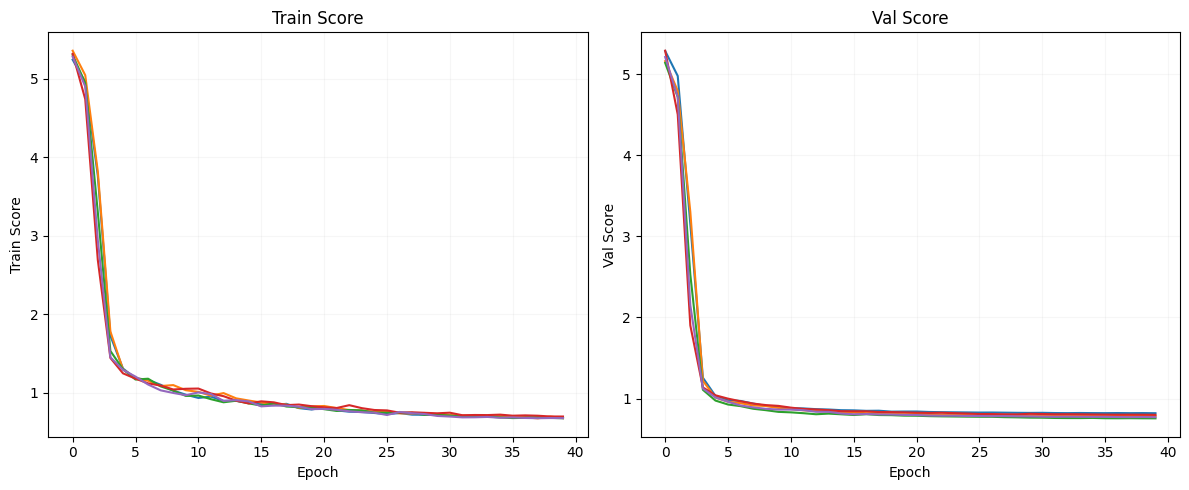

In [21]:
main()

# inference

In [22]:
class EnsembleModel:
    def __init__(self):
        self.models = []

    def __call__(self, x):
        outputs = []
        for model in self.models:
            if CFG.objective_cv == 'binary':
                outputs.append(torch.sigmoid(model(x)).to('cpu').numpy())
            elif CFG.objective_cv == 'multiclass':
                outputs.append(torch.softmax(
                    model(x), axis=1).to('cpu').numpy())
            elif CFG.objective_cv == 'regression':
                outputs.append(model(x).to('cpu').numpy())

        avg_preds = np.mean(outputs, axis=0)
        return avg_preds

    def add_model(self, model):
        self.models.append(model)


def test_fn(valid_loader, model, device):
    preds = []

    for step, (images) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)

        with torch.no_grad():
            y_preds = model(images)

        preds.append(y_preds)

    predictions = np.concatenate(preds)
    return predictions


def inference():
    test = pd.read_csv(CFG.comp_dataset_path +
                       'test_features.csv')

    test['base_path'] = CFG.comp_dataset_path + 'images/' + test['ID'] + '/'

    paths = []
    for base_path in test['base_path'].values:
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix
            paths.append(path)

    print(paths[:5])

    CFG.video_cache = make_video_cache(paths)

    print(test.head(5))

    valid_dataset = CustomDataset(
        test, CFG, transform=get_transforms(data='valid', cfg=CFG))
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    model = EnsembleModel()
    folds = [0] if CFG.use_holdout else list(range(CFG.n_fold))
    for fold in folds:
        _model = CustomModel(CFG, pretrained=False)
        _model.to(device)

        model_path = CFG.model_dir + \
            f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth'
        print('load', model_path)
        state = torch.load(model_path)['model']
        _model.load_state_dict(state)
        _model.eval()

        # _model = tta.ClassificationTTAWrapper(
        #     _model, tta.aliases.five_crop_transform(256, 256))

        model.add_model(_model)

    preds = test_fn(valid_loader, model, device)

    test[CFG.target_col] = preds
    test.to_csv(CFG.submission_dir +
                'submission_oof.csv', index=False)
    test[CFG.target_col].to_csv(
        CFG.submission_dir + f'submission_{CFG.exp_name}.csv', index=False)

In [23]:
inference()

['../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t-1.0.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t-0.5.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_220/image_t-1.0.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_220/image_t-0.5.png']
[255, 227, 199, 170, 142, 114, 85, 57, 29]


0it [00:00, ?it/s]

                                     ID      vEgo      aEgo  steeringAngleDeg  \
0  012baccc145d400c896cb82065a93d42_120  3.374273 -0.019360        -34.008415   
1  012baccc145d400c896cb82065a93d42_220  2.441048 -0.022754        307.860077   
2  012baccc145d400c896cb82065a93d42_320  3.604152 -0.286239         10.774388   
3  012baccc145d400c896cb82065a93d42_420  2.048902 -0.537628         61.045235   
4  01d738e799d260a10f6324f78023b38f_120  2.201528 -1.898600          5.740093   

   steeringTorque  brake  brakePressed  gas  gasPressed gearShifter  \
0            17.0    0.0         False  0.0       False       drive   
1           295.0    0.0          True  0.0       False       drive   
2          -110.0    0.0          True  0.0       False       drive   
3           189.0    0.0          True  0.0       False       drive   
4           -41.0    0.0          True  0.0       False       drive   

   leftBlinker  rightBlinker  \
0        False         False   
1        False        

/tmp/ipykernel_217129/610043316.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)['model']


load ../proc/baseline/outputs/atmacup_18_cnn_swin_small_2/atmacup_18-models/swin_small_patch4_window7_224_fold1_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_swin_small_2/atmacup_18-models/swin_small_patch4_window7_224_fold2_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_swin_small_2/atmacup_18-models/swin_small_patch4_window7_224_fold3_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_swin_small_2/atmacup_18-models/swin_small_patch4_window7_224_fold4_last.pth


  0%|          | 0/14 [00:00<?, ?it/s]